# Optimisation stochastique d'un mix électrique (thermique; renouvelable; hydraulique)

Ce notebook étudie un problème de **Unit Commitment stochastique** pour un système électrique composé :
- de groupes thermiques (coûts variables et émissions de CO$_2$),
- de groupes de production renouvelable,
- d'un réservoir hydraulique 

L'objectif est de planifier l'engagement et la production de ces unités sur un horizon discret (68 pas de temps) en présence d'incertitudes :
- sur la demande,
- sur la production renouvelable,
- sur les apports hydrauliques.

Le modèle est **multi‑objectif** : il cherche un compromis entre
- le coût économique (coûts variables + démarrage + pénalités de délestage),
- les émissions de CO$_2$, 
- la valorisation de l'eau stockée en fin d'horizon.

Plusieurs briques sont développées dans ce carnet :
1. Génération des données et des distributions d'incertitude (thermique, renouvelable, demande, hydraulique).
2. Construction de scénarios stochastiques.
3. Formulation et résolution d'un MIP stochastique avec PuLP (CBC ou CPLEX).
4. Comparaison de stratégies **déterministe** vs **stochastique** sur des scénarios de test.
5. Construction d'un **front de Pareto** coût/CO$_2$ et analyse de robustesse.


In [3]:
import pulp 

In [4]:

from pulp import (
    LpProblem, LpMinimize, LpVariable, LpBinary, LpContinuous,
    lpSum, LpStatus, value, PULP_CBC_CMD
)

# =======================
# Raw data (full 65 periods)
# =======================


In [5]:
import numpy as np

## Données

Cette section construit l'ensemble des **données d'entrée** du problème :
- courbe de consommation sur 68 pas de temps,
- profils de production renouvelable,
- caractéristiques techniques et économiques des groupes thermiques (Pmin/Pmax, coûts, gradients, durées minimales, coûts de démarrage, états initiaux),
- paramètres agrégés de l'hydraulique (puissance maximale, volume, inflows, valorisation de l'eau).

Les vecteurs globaux (tous types de groupes confondus) sont ensuite construits pour alimenter les modèles déterministes et stochastiques.

In [ ]:
# ==========================================
# Données Unit Commitment
# ==========================================

NbPdt = 68 
NbGroupeThermique = 19
NbGroupeFatal = 9  

G  = NbGroupeThermique
GF = NbGroupeFatal

# Courbe de consommation (68 points) 
Conso = [219, 198, 179, 162, 152, 146, 142, 140, 139, 140, 145, 151, 162, 176, 190, 211, 216, 231, 235, 240, 240, 240, 240, 238, 236, 230, 226, 223, 220, 217, 213, 211, 210, 210, 210, 214, 223, 234, 250, 260, 283, 272, 256, 237, 239, 247, 236, 215, 226, 204, 183, 166, 157, 150, 147, 145, 144, 146, 150, 155, 165, 179, 192, 211, 219, 233, 240, 242]

# Données brutes des 4 profils fiables
_profils_fiables = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 6, 10, 14, 16, 18, 20, 22, 24, 25, 25, 25, 24, 23, 22, 20, 18, 16, 11, 6, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 6, 9, 12, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 3, 3, 4, 5, 6, 7, 7, 7, 7, 7, 6, 6, 5, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
]

# On génère 9 listes en cyclant sur les 4 profils disponibles
ProductionFatale = [_profils_fiables[i % 4] for i in range(NbGroupeFatal)]

# Données Thermiques (19 Groupes - Données fiables)
TauxCO2Thermique = [378, 361, 358, 381, 366, 365, 364, 409, 428, 408, 426, 428, 434, 422, 182, 198, 194, 181, 180]
CoutThermiqueMoyen = [60, 60, 60, 60, 60, 60, 60, 270, 270, 270, 270, 270, 270, 270, 150, 150, 150, 110, 110]

PmaxTechniqueThermique = [16, 16, 16, 16, 16, 16, 16, 19, 19, 19, 19, 19, 19, 19, 17, 19, 26, 42, 20]
PminTechniqueThermique = [6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 7, 8, 10, 17, 8] 

GradientThermiqueParPasDeTemps = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 7, 10, 22, 9]
TauxCO2Fatal = [0] * NbGroupeFatal

DureeMinMarcheThermiquePdt = [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0]
DureeMinArretThermiquePdt = [4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0]
CoutDemarrageFroidThermique = [3529, 4023, 3533, 2716, 1924, 4171, 2734, 3341, 3059, 3662, 3379, 3331, 3543, 2288, 1803, 786, 946, 2053, 5146]
EtatInitialThermique = [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0]
DureeEtatInitialThermiquePdt = [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0]


HORIZON = 68                     
T_full  = len(Conso)             
T       = min(HORIZON, T_full)   


fatal_sum = [sum(ProductionFatale[f][t] for f in range(GF)) for t in range(T)]
residual_demand = [Conso[t] - fatal_sum[t] for t in range(T)]

# ==========================================
# Construction des vecteurs globaux
# ==========================================
# Nombre total d'unités
G_total = G + GF
thermal_indices = list(range(G))
renewable_indices = list(range(G, G + GF))

# Pmin / Pmax
Pmin_all = PminTechniqueThermique[:G] + [0]*GF
Pmax_all = PmaxTechniqueThermique[:G] + [max(ProductionFatale[f][:T]) for f in range(GF)]

# Cout moyen
Cout_all = CoutThermiqueMoyen[:G] + [10]*GF  # coût marginal pour renouvelable = 10

# Taux CO2
TauxCO2_all = TauxCO2Thermique[:G] + [0]*GF 

# Gradient max (pour l'instant 0 pour renouvelables)
Gradient_all = GradientThermiqueParPasDeTemps[:G] + [0]*GF

# Durée min marche / arrêt (pour renouvelables = 0)
DureeMinMarche_all = DureeMinMarcheThermiquePdt[:G] + [0]*GF
DureeMinArret_all = DureeMinArretThermiquePdt[:G] + [0]*GF

# Coût démarrage (0 pour renouvelables)
CoutDemarrage_all = CoutDemarrageFroidThermique[:G] + [0]*GF

# Etat initial et durée état initial
EtatInitial_all = EtatInitialThermique[:G] + [0]*GF
DureeEtatInitial_all = DureeEtatInitialThermiquePdt[:G] + [0]*GF

# Vérification
print("Longueur listes:", len(Pmin_all), len(Pmax_all), len(Cout_all), len(TauxCO2_all))

# =======================
# Données Hydrauliques (Agrégées depuis le jeu fiable 16 groupes/9 réservoirs)
# =======================

Hydro_Pmax = 80.0      
Hydro_Vmax = 300.0    
Hydro_Vmin = 0.0     
# Volume Initial ajusté
Hydro_Vinit = 100.0    
# Prix ajusté pour le peaking (Omega > Couts Thermiques de base)
Hydro_Omega = 70.0      

# Inflow ajusté pour ne pas submerger le petit réservoir
Mu_Inflow = 1.0         
Sigma_Inflow = 0.5

Longueur listes: 28 28 28 28


### Définition des variables aléatoires et distribution

On définit ici les **lois de probabilité** qui représentent les incertitudes du système :
- facteurs multiplicatifs sur la capacité des groupes thermiques,
- facteurs multiplicatifs sur la capacité des groupes renouvelables,
- bruit gaussien sur la demande, autour de la courbe de consommation de référence.

Ces distributions seront utilisées pour générer des scénarios cohérents de production disponible, de demande et d'apports hydrauliques.

In [ ]:
import numpy as np

# =======================
# Facteur aléatoire pour les centrales thermiques
# =======================
# On suppose gamma_j ~ N(1, sigma_j^2) pour chaque centrale thermique
sigma_therm = [0.05]*G  # 5% d'incertitude par défaut
gamma_therm = [{'mu': 1.0, 'sigma': sigma_therm[j]} for j in range(G)]

# =======================
# Facteur aléatoire pour les centrales renouvelables (fatales)
# =======================
# Même idée : gamma_f ~ N(1, sigma_f^2)
sigma_renew = [0.1]*GF  # plus incertitude pour les ENR
gamma_renew = [{'mu': 1.0, 'sigma': sigma_renew[f]} for f in range(GF)]

# =======================
# Modélisation aléatoire de la demande
# =======================
# Demande = Conso initiale + bruit gaussien
sigma_demand = 5.0  # MW
demand_distrib = [{'mu': Conso[t], 'sigma': sigma_demand} for t in range(T)]

# =======================
# Les données sont maintenant préparées pour le MIP stochastique
# =======================

### Génération des scénarios (gestion stochastique) : tirage des variables aléatoires

La fonction `generate_scenarios` construit un **ensemble de scénarios** pour le modèle stochastique. Pour chaque scénario et chaque pas de temps, on tire :
- des courbes Pmin/Pmax pour chaque groupe thermique,
- des courbes Pmax pour chaque groupe renouvelable (Pmin = 0),
- une courbe de demande,
- une trajectoire d'inflows hydrauliques.

Ces scénarios servent de base à la formulation du problème de Unit Commitment stochastique avec hydraulique.

In [9]:
def generate_scenarios(S):
    """
    Retourne les données nécessaires au MIP avec tirage aléatoire des incertitudes.
    Pmin/Pmax Thermiques ET Renouvelables sont variabilisés par pas de temps t.
    """
    # Initialisation des structures (Matrices S x (G+GF))
    Pmin_stoch = [[None for a in range(G+GF)] for s in range(S)]
    Pmax_stoch = [[None for a in range(G+GF)] for s in range(S)]
    demand_stoch = [[0 for t in range(T)] for s in range(S)]
    inflows_stoch = [[0 for t in range(T)] for s in range(S)]
    
    for s in range(S):
        
        # 1. Stochastic tirage des pmin, pmax THERMIQUES (Indices 0 à G)
        # On boucle sur t pour avoir du bruit horaire
        for j in range(G):
            
            pmin_curve_s = []
            pmax_curve_s = []
            
            for t in range(T):
                # Tirage d'un aléa pour cet instant t
                gamma_th = np.random.normal(loc=gamma_therm[j]['mu'], scale=gamma_therm[j]['sigma'])
                gamma_th = max(0.0, gamma_th) # Sécurité physique
                
                # Calcul des limites à l'instant t
                val_min = Pmin_all[j] * gamma_th
                val_max = Pmax_all[j] * gamma_th
                
                pmin_curve_s.append(val_min)
                pmax_curve_s.append(val_max)
            
            # On stocke les listes complètes
            Pmin_stoch[s][j] = pmin_curve_s
            Pmax_stoch[s][j] = pmax_curve_s

        # 2. Stochastic tirage RENOUVELABLE (Indices G à G+GF)
        for j_rel in range(GF):
            j_glob = G + j_rel
            
            pmax_curve_s = []
            
            for t in range(T):
                gamma_t = np.random.normal(loc=gamma_renew[j_rel]['mu'], scale=gamma_renew[j_rel]['sigma'])
                gamma_t = max(0.0, gamma_t)
                
                # Bruit blanc sur la capacité installée
                val_t = Pmax_all[j_glob] * gamma_t
                pmax_curve_s.append(val_t)

            Pmax_stoch[s][j_glob] = pmax_curve_s
            # Pmin est 0 (ou une liste de 0)
            Pmin_stoch[s][j_glob] = [0.0] * T

        # 3. Stochastic tirage de la demande
        for t in range(T):
            demand_stoch[s][t] = np.random.normal(loc=demand_distrib[t]['mu'], scale=demand_distrib[t]['sigma'])
            
        # 4. Stochastic tirage des apports hydrauliques
        for t in range(T):
            val = np.random.normal(loc=Mu_Inflow, scale=Sigma_Inflow)
            inflows_stoch[s][t] = max(0.0, val)

    return Pmin_stoch, Pmax_stoch, demand_stoch, inflows_stoch

### Définition du modèle d'optimisation multi-objectif cplex

Cette section définit le **modèle MIP stochastique** avec hydraulique. On y introduit :
- les variables binaires d'engagement, démarrage et arrêt pour chaque groupe, communes à tous les scénarios (Here-and-Now),
- les variables continues de production, de délestage et d'hydraulique (production, stock, déversement) par scénario (Wait-and-See),
- les contraintes techniques (Pmin/Pmax, gradients, durées minimales, dynamique du réservoir, équilibre offre/demande),
- une fonction objectif qui agrège coût économique, émissions de CO$_2$, pénalités de délestage et valorisation finale de l'eau.

In [ ]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, LpContinuous

def stochastic_model_with_hydro(lamb, S, Pmin_scen, Pmax_scen, residual_demand_scen, inflows_scen):
    """
    Modèle stochastique Unit Commitment avec composante Hydraulique (Reservoir).
    """
    
    m = LpProblem("UnitCommitment_Stochastic_Hydro", LpMinimize)

    # =======================
    # A. Variables Thermiques / Système
    # =======================
    # Here-and-Now
    u = {(j, t): LpVariable(f"u_{j}_{t}", cat=LpBinary) for j in range(G+GF) for t in range(T)}
    v = {(j, t): LpVariable(f"v_{j}_{t}", cat=LpBinary) for j in range(G+GF) for t in range(T)}
    w = {(j, t): LpVariable(f"w_{j}_{t}", cat=LpBinary) for j in range(G+GF) for t in range(T)}

    # Wait-and-See
    p = {(j, t, s): LpVariable(f"p_{j}_{t}_s{s}", lowBound=0, cat=LpContinuous)
         for j in range(G+GF) for t in range(T) for s in range(S)}
    shed = {(t, s): LpVariable(f"shed_{t}_s{s}", lowBound=0, cat=LpContinuous)
            for t in range(T) for s in range(S)}

    # =======================
    # B. Variables Hydrauliques (Wait-and-See)
    # =======================
    # h_gen : Production hydroélectrique (MW)
    # h_vol : Volume du réservoir à la fin de l'heure t (MWh)
    # h_spill : Déversement (eau jetée si réservoir plein) (MW/h)
    
    h_gen = {(t, s): LpVariable(f"h_gen_{t}_{s}", lowBound=0, upBound=Hydro_Pmax, cat=LpContinuous)
             for t in range(T) for s in range(S)}
             
    h_vol = {(t, s): LpVariable(f"h_vol_{t}_{s}", lowBound=Hydro_Vmin, upBound=Hydro_Vmax, cat=LpContinuous)
             for t in range(T) for s in range(S)}
             
    h_spill = {(t, s): LpVariable(f"h_spill_{t}_{s}", lowBound=0, cat=LpContinuous)
               for t in range(T) for s in range(S)}

    # =======================
    # C. Contraintes
    # =======================
    
    for s in range(S):
        # --- 1. Contraintes Thermiques ---
        for t in range(T):
            
            # Pour TOUTES les unités (Thermique ET Renouvelable)
            for j in range(G + GF):
                T
                limit_pmax = Pmax_scen[s][j][t]
                limit_pmin = Pmin_scen[s][j][t]
                
                # Contrainte Pmax
                m += p[(j, t, s)] <= limit_pmax * u[(j, t)]
                
                # Contrainte Pmin
                m += p[(j, t, s)] >= limit_pmin * u[(j, t)]

            # Force u=1 pour les renouvelables (Must Run)
            # (Indices G à G+GF)
            for j in range(G, G + GF):
                m += u[(j, t)] == 1
        
        # Gradients
        for j in range(G):
            grad_max = Gradient_all[j]
            for t in range(1, T):
                m += p[(j, t, s)] - p[(j, t-1, s)] <= grad_max
                m += p[(j, t-1, s)] - p[(j, t, s)] <= grad_max

        # --- 2. Contraintes Hydrauliques (Dynamique de stock) ---
        # Volume(t) = Volume(t-1) - Turbinage + Apports - Deversement
        # Pour t=0 :
        m += h_vol[(0, s)] == Hydro_Vinit - h_gen[(0, s)] + inflows_scen[s][0] - h_spill[(0, s)], f"hydro_bal_0_s{s}"
        
        # Pour t>0 :
        for t in range(1, T):
            m += h_vol[(t, s)] == h_vol[(t-1, s)] - h_gen[(t, s)] + inflows_scen[s][t] - h_spill[(t, s)], f"hydro_bal_{t}_s{s}"

        m += h_vol[(T-1, s)] >= Hydro_Vinit
        # --- 3. Équilibre Offre-Demande Global ---
        # Somme(Thermique) + Hydro = Demande + Shed
        for t in range(T):
            total_therm = lpSum(p[(j, t, s)] for j in range(G+GF))
            m += total_therm + h_gen[(t, s)] == residual_demand_scen[s][t] - shed[(t, s)], f"power_balance_t{t}_s{s}"

    # --- 4. Contraintes Logiques (Here-and-Now) ---
    for j in range(G+GF):
        m += u[(j, 0)] - EtatInitial_all[j] == v[(j, 0)] - w[(j, 0)]
        for t in range(1, T):
            m += u[(j, t)] - u[(j, t-1)] == v[(j, t)] - w[(j, t)]
        
        L_up = DureeMinMarche_all[j]
        L_dn = DureeMinArret_all[j]
        
        if L_up > 0:
            for t in range(T):
                start_window = range(max(0, t - L_up + 1), t + 1)
                m += lpSum(v[(j, k)] for k in start_window) <= u[(j, t)]
        if L_dn > 0:
            for t in range(T):
                shut_window = range(max(0, t - L_dn + 1), t + 1)
                m += lpSum(w[(j, k)] for k in shut_window) <= 1 - u[(j, t)]
                
    # =======================
    # D. Fonction Objectif
    # =======================
    BIG_SHED   = 1e6 
    
    # Coûts moyennés sur les scénarios
    gen_cost   = lpSum(Cout_all[j] * p[(j, t, s)] for j in range(G+GF) for t in range(T) for s in range(S)) / S
    gen_co2    = lpSum(TauxCO2_all[j] * p[(j, t, s)] for j in range(G+GF) for t in range(T) for s in range(S)) / S
    shed_pen   = lpSum(BIG_SHED * shed[(t, s)] for t in range(T) for s in range(S)) / S
    
    # Coût fixe (unique)
    start_cost = lpSum(CoutDemarrage_all[j] * v[(j, t)] for j in range(G+GF) for t in range(T))
    
    # VALORISATION DE L'EAU (Terme négatif car c'est un gain)
    # On valorise le volume restant à la fin de l'horizon (T-1) au prix Omega
    # E[Gain Eau] = Somme(Omega * Vol_Final_s) / S
    water_value = lpSum(Hydro_Omega * h_vol[(T-1, s)] for s in range(S)) / S

    # Minimiser : Coûts - ValeurEauFinale
    m += gen_cost + start_cost + lamb*gen_co2 + shed_pen - water_value

    return m, u, v, w, p, shed, h_gen, h_vol

### Résolution du multi scénarios

On génère ici un petit nombre de scénarios, on construit le modèle stochastique avec hydraulique puis on le **résout** avec CBC ou CPLEX. Cette étape permet :
- de vérifier la cohérence du modèle et des scénarios,
- d'obtenir une première stratégie stochastique d'engagement des unités,
- d'inspecter rapidement les niveaux de production (en particulier des renouvelables).

In [ ]:
# Génération des scénarios (avec hydraulique)
Pmin_s, Pmax_s, demand_s, inflows_s = generate_scenarios(S=5)

# Création du modèle
model_stoch, u_stoch, v_stoch, w_stoch, p_stoch, shed_stoch, h_gen_stoch, h_vol_stoch = stochastic_model_with_hydro(
    lamb=0.1, 
    S=5, 
    Pmin_scen=Pmin_s, 
    Pmax_scen=Pmax_s, 
    residual_demand_scen=demand_s,
    inflows_scen=inflows_s
) 

# Choix du solveur
solver = None
try:
    from pulp import CPLEX_CMD
    solver = CPLEX_CMD(msg=True, timeLimit=None, options=['set mip display 1', 'set timelimit 999999'])
except Exception:
    solver = None

if solver is None:
    print("CPLEX not found by PuLP; falling back to CBC.")
    solver = PULP_CBC_CMD(msg=True)

# Résolution
model_stoch.solve(solver)

print(f"Status: {model_stoch.status}, Objectif: {value(model_stoch.objective)}")

Test variabilité Renouvelable (Scénario 0, Unité G) :
[25.6008495732242, 24.574957952763988, 24.963221263908338, 22.085638262461362, 23.47759898786413, 20.853318668352482, 27.975069918150798, 23.11591068797433, 24.234334874389457, 24.263303037008598, 19.0804010567292, 25.064261142913086, 26.78362220394185, 26.76156254901634, 27.962703153487755, 22.361224231668935, 23.065750940870505, 20.596455517597782, 29.414767475355813, 24.927554593248917, 28.870680964719796, 22.544289232060827, 24.55915185741035, 27.031262164075763, 23.059040662424756, 26.680378203666887, 28.741730876116783, 17.993699063758328, 23.278678538083863, 23.939471216557063, 24.297034416066825, 28.836454272067808, 28.540088633651756, 28.930681229835763, 26.404970739426236, 30.868697606103122, 19.461308216760322, 25.07868641260786, 24.268590033478823, 24.168660289095918, 28.096381608158648, 24.360271873672325, 28.25490322030044, 25.53815687330147, 26.0146143074361, 27.908145767994384, 24.63453006736333, 22.247815179351008, 

## Test de la robustesse sur d'autres scénarios

Cette section extrait la **stratégie d'engagement** issue du modèle stochastique (valeurs binaires des variables $u, v, w$) et prépare les outils pour tester sa robustesse. On définit :
- une fonction `extract_strategy` qui fige les décisions entières,
- des fonctions de génération de nouveaux scénarios et d'évaluation de ces scénarios.

On peut ainsi comparer, sur des réalisations inédites, le comportement d'une politique déterministe et d'une politique stochastique.

In [12]:
def extract_strategy(u_vars, v_vars, w_vars):
    """
    Extrait les valeurs binaires (0 ou 1) de la solution.
    CORRECTION : Utilisation de .varValue au lieu de value(...) pour éviter les conflits.
    """
    u_fixed = {}
    v_fixed = {}
    w_fixed = {}
    
    # Pour u
    for key in u_vars:
        val = u_vars[key].varValue
        # Sécurité : si la variable n'a pas de valeur (cas d'erreur solver), on met 0
        if val is None: val = 0 
        u_fixed[key] = int(round(val))
        
    # Pour v
    for key in v_vars:
        val = v_vars[key].varValue
        if val is None: val = 0
        v_fixed[key] = int(round(val))

    # Pour w
    for key in w_vars:
        val = w_vars[key].varValue
        if val is None: val = 0
        w_fixed[key] = int(round(val))
        
    return u_fixed, v_fixed, w_fixed

## Génération d'un nouveau scénario. plusieurs lois possibles

La fonction `generate_single_scenario` permet de tirer **un scénario de test** à la demande. Plusieurs modes sont disponibles (`normal`, `uniform`, `extreme`, `stress`) pour moduler :
- le niveau d'incertitude sur la production thermique et renouvelable,
- la sévérité des variations de demande,
- la sévérité des conditions hydrauliques.

Ces scénarios servent de banc d'essai pour mesurer la performance et la robustesse d'une stratégie donnée.

In [13]:
def generate_single_scenario(mode='normal'):
    """
    Génère les données pour UN seul scénario (Thermique + ENR + Demande + Hydro).
    Adaptation : Génère des LISTES (courbes) pour Pmin/Pmax au lieu de valeurs uniques.
    """
    # Initialisation avec des listes vides
    Pmin_1 = [None] * (G + GF)
    Pmax_1 = [None] * (G + GF)
    demand_1 = [0] * T
    inflows_1 = [0] * T 
    
    # --- 1. Offre Thermique & ENR (Variabilisée par t) ---
    for j in range(G + GF):
        
        # Récupération des params
        if j < G:
            mu, sigma = gamma_therm[j]['mu'], gamma_therm[j]['sigma']
            is_renew = False
        else:
            idx = j - G
            mu, sigma = gamma_renew[idx]['mu'], gamma_renew[idx]['sigma']
            is_renew = True

        # Génération de la courbe Pmin/Pmax heure par heure
        pmin_curve = []
        pmax_curve = []
        
        for t in range(T):
            gamma = 1.0
            
            # Logique du Mode
            if mode == 'normal':
                gamma = np.random.normal(mu, sigma)
            elif mode == 'uniform':
                low, high = max(0, mu - 2*sigma), mu + 2*sigma
                gamma = np.random.uniform(low, high)
            elif mode == 'extreme':
                gamma = np.random.normal(mu, sigma * 2.0)
            elif mode == 'stress':
                if is_renew:
                    gamma = np.random.normal(mu * 0.95, sigma) # -10% vent/soleil
                else:
                    gamma = np.random.normal(mu, sigma)
            
            # Sécurité physique
            gamma = max(0.0, gamma)
            
            # Calcul pour cet instant t
            # Note: Pour le thermique, Pmin_all[j] est fixe, mais gamma change à chaque heure => bruit
            val_min = Pmin_all[j] * gamma
            val_max = Pmax_all[j] * gamma
            
            # Si c'est du renouvelable, Pmin est forcé à 0
            if is_renew:
                val_min = 0.0

            pmin_curve.append(val_min)
            pmax_curve.append(val_max)
            
        # Assignation des courbes complètes
        Pmin_1[j] = pmin_curve
        Pmax_1[j] = pmax_curve

    # --- 2. Demande ---
    for t in range(T):
        mu_d, sigma_d = demand_distrib[t]['mu'], demand_distrib[t]['sigma']
        val = 0
        if mode == 'stress':
            val = np.random.normal(mu_d * 1.05, sigma_d) # +10% demande
        else:
            val = np.random.normal(mu_d, sigma_d)
        demand_1[t] = val
        
    # --- 3. Apports Hydrauliques (Inflows) ---
    for t in range(T):
        if mode == 'stress':
             # Sécheresse : -20% d'eau
            val = np.random.normal(Mu_Inflow * 0.9, Sigma_Inflow)
        else:
            val = np.random.normal(Mu_Inflow, Sigma_Inflow)
        inflows_1[t] = max(0.0, val)

    return Pmin_1, Pmax_1, demand_1, inflows_1

## Fonction de calcul du cout et du co2 pour un nouveau scénario

La fonction `evaluate_scenario` résout, pour un scénario donné, un **problème de dispatch économique** en fixant la stratégie d'engagement (u, v, w). Elle calcule :
- le coût opérationnel (variable + délestage − valeur de l'eau),
- les coûts de démarrage associés à la stratégie,
- les émissions de CO$_2$ et la présence éventuelle de délestage.

Elle est utilisée pour comparer, sur la même réalisation aléatoire, différentes stratégies (déterministe vs stochastique).

In [ ]:
def evaluate_scenario(u_fixed, v_fixed, w_fixed, Pmin_scen, Pmax_scen, demand_scen, inflows_scen, lamb):
    """
    Résout le dispatch (LP) pour un scénario donné en imposant la stratégie thermique (u, v, w).
    Adaptation : Lit Pmin_scen[j] comme une liste temporelle.
    """
    # Création du modèle LP
    m_eval = LpProblem("Eval_Dispatch_Hydro", LpMinimize)
    
    # --- Variables Wait-and-See ---
    p_eval = {(j, t): LpVariable(f"p_{j}_{t}", lowBound=0, cat=LpContinuous) for j in range(G+GF) for t in range(T)}
    shed_eval = {t: LpVariable(f"shed_{t}", lowBound=0, cat=LpContinuous) for t in range(T)}
    
    # Hydraulique
    h_gen = {t: LpVariable(f"h_gen_{t}", lowBound=0, upBound=Hydro_Pmax, cat=LpContinuous) for t in range(T)}
    h_vol = {t: LpVariable(f"h_vol_{t}", lowBound=Hydro_Vmin, upBound=Hydro_Vmax, cat=LpContinuous) for t in range(T)}
    h_spill = {t: LpVariable(f"h_spill_{t}", lowBound=0, cat=LpContinuous) for t in range(T)}

    # --- Contraintes ---
    
    # 1. Bilan Hydraulique (Stock)
    m_eval += h_vol[0] == Hydro_Vinit - h_gen[0] + inflows_scen[0] - h_spill[0]
    for t in range(1, T):
        m_eval += h_vol[t] == h_vol[t-1] - h_gen[t] + inflows_scen[t] - h_spill[t]

    m_eval += h_vol[T-1] >= Hydro_Vinit

    # 2. Équilibre Offre-Demande
    for t in range(T):
        m_eval += lpSum(p_eval[(j, t)] for j in range(G+GF)) + h_gen[t] == demand_scen[t] - shed_eval[t]
        
        # Bornes thermiques (fixées par u_fixed)
        for j in range(G+GF):            
            if j < G:
                status = u_fixed[(j, t)]
            else:
                status = 1.0 
            
            limit_min = Pmin_scen[j][t]
            limit_max = Pmax_scen[j][t]
            
            m_eval += p_eval[(j, t)] >= limit_min * status
            m_eval += p_eval[(j, t)] <= limit_max * status
            
            # Gradients (uniquement thermique)
            if j < G and t > 0:
                grad = Gradient_all[j]
                m_eval += p_eval[(j, t)] - p_eval[(j, t-1)] <= grad
                m_eval += p_eval[(j, t-1)] - p_eval[(j, t)] <= grad

    # --- Objectif ---
    BIG_SHED = 1e6
    
    var_cost = lpSum(Cout_all[j] * p_eval[(j, t)] for j in range(G+GF) for t in range(T))
    co2_load = lpSum(TauxCO2_all[j] * p_eval[(j, t)] for j in range(G+GF) for t in range(T))
    shed_cost = lpSum(BIG_SHED * shed_eval[t] for t in range(T))
    
    water_value = Hydro_Omega * h_vol[T-1]

    m_eval += var_cost + lamb * co2_load + shed_cost - water_value

    m_eval.solve(PULP_CBC_CMD(msg=False))
    
    # --- Calcul des Résultats ---
    startup_cost_total = sum(CoutDemarrage_all[j] * v_fixed[(j, t)] for j in range(G) for t in range(T)) # range(G) car pas de start cost renouvelable
    
    operational_cost = value(var_cost) + value(shed_cost) - value(water_value)
    
    total_financial_cost = startup_cost_total + operational_cost
    total_co2 = value(co2_load)
    
    total_shed_expr = lpSum(shed_eval[t] for t in range(T))
    has_shed = value(total_shed_expr) > 1e-3

    return total_financial_cost, total_co2, has_shed

## Appel

Ce bloc assemble toutes les briques précédentes pour un **scénario de test unique** :
1. extraction d'une stratégie stochastique à partir du modèle multi‑scénarios,
2. génération d'un scénario de test (ici en mode `stress`),
3. résolution du problème de dispatch sur ce scénario et calcul des indicateurs (coût, CO$_2$, délestage).

In [ ]:
# 1. Extraction (avec w)
# Pas de changement ici : l'hydro est gérée en "Wait-and-See" (variables continues),
# donc on ne fixe que les décisions binaires thermiques.
u_opt, v_opt, w_opt = extract_strategy(u_stoch, v_stoch, w_stoch)

# 2. Génération 
# # On récupère  4 variables : Pmin, Pmax, Demande, et Inflows (apports d'eau)
pm_test, pM_test, d_test, infl_test = generate_single_scenario(mode='stress')

# 3. Évaluation 
cout, co2, shed = evaluate_scenario(
    u_opt, v_opt, w_opt, 
    pm_test, pM_test, d_test, infl_test, 
    lamb=0.1
)

print(f"Coût Net: {cout:,.0f} €, CO2: {co2:,.2f} t, Délestage: {shed}")

Coût Net: 168,996,343 €, CO2: 2,768,903.29 t, Délestage: True


In [ ]:
# =========================================================
# Fonction pour générer les données DÉTERMINISTES avec Hydro
# =========================================================
def generate_deterministic_data_hydro():
    """
    S=1, tout à la moyenne (y compris Inflows).
    Adaptation : Génère des LISTES pour Pmin/Pmax (profils plats à la moyenne).
    """
    # Initialisation : S=1, donc une seule liste dans la première dimension
    Pmin_d = [[None for _ in range(G+GF)]]
    Pmax_d = [[None for _ in range(G+GF)]]
    dem_d = [[0]*T]
    infl_d = [[0]*T]
    
    # 1. Offre (Thermique + Renouvelable) à la moyenne
    for j in range(G + GF):
        
        # Récupération de la moyenne (mu)
        if j < G:
            mu = gamma_therm[j]['mu']
        else:
            idx = j - G
            mu = gamma_renew[idx]['mu']
            
        # Calcul des valeurs moyennes (Scalaires)
        val_min = Pmin_all[j] * mu
        val_max = Pmax_all[j] * mu
        
        # Si renouvelable, Pmin = 0
        if j >= G:
            val_min = 0.0
            
        Pmin_d[0][j] = [val_min] * T
        Pmax_d[0][j] = [val_max] * T

    # 2. Demande & Inflows à la moyenne
    for t in range(T):
        dem_d[0][t] = demand_distrib[t]['mu']
        infl_d[0][t] = Mu_Inflow # Valeur moyenne constante
        
    return Pmin_d, Pmax_d, dem_d, infl_d

>>> 1. Calcul Stratégie DÉTERMINISTE (Moyenne)... Ok.
>>> 2. Calcul Stratégie STOCHASTIQUE (5 scénarios)... Ok.
>>> 3. Tirage d'un scénario de test (Mode NORMAL)...
>>> 4. Simulation du Dispatch Économique...

=================== STRATÉGIE DÉTERMINISTE ====================


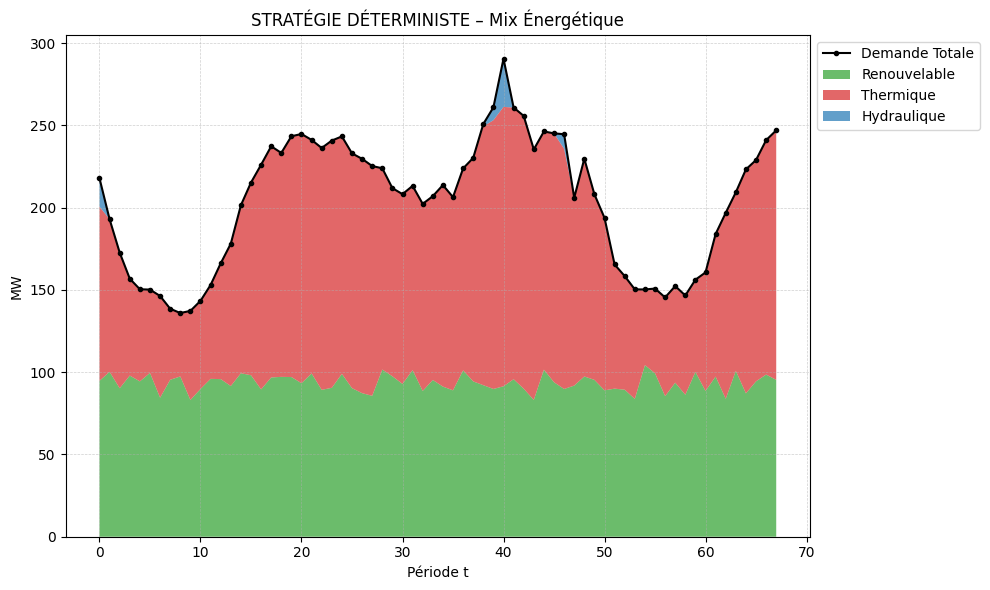

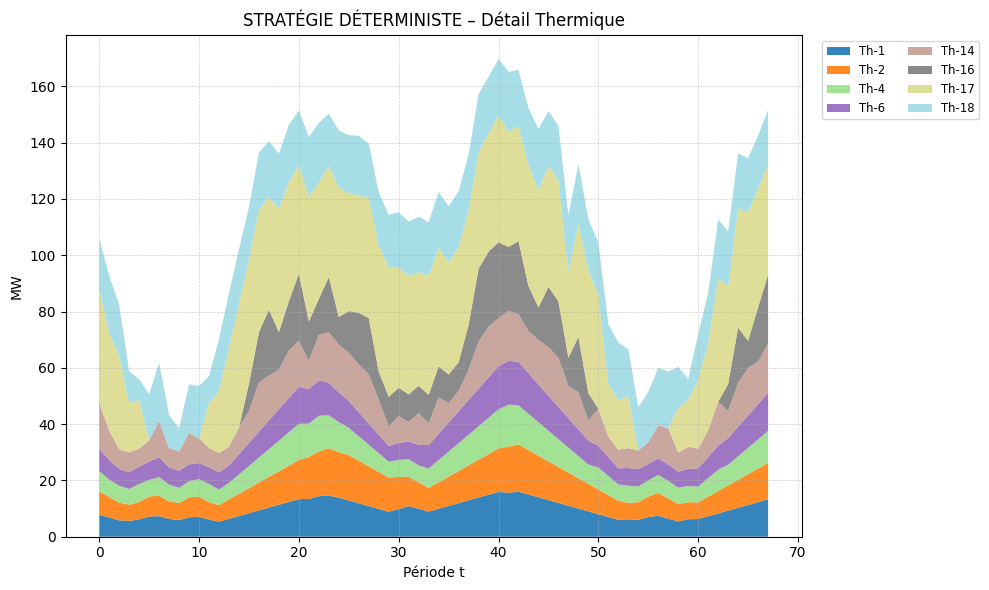

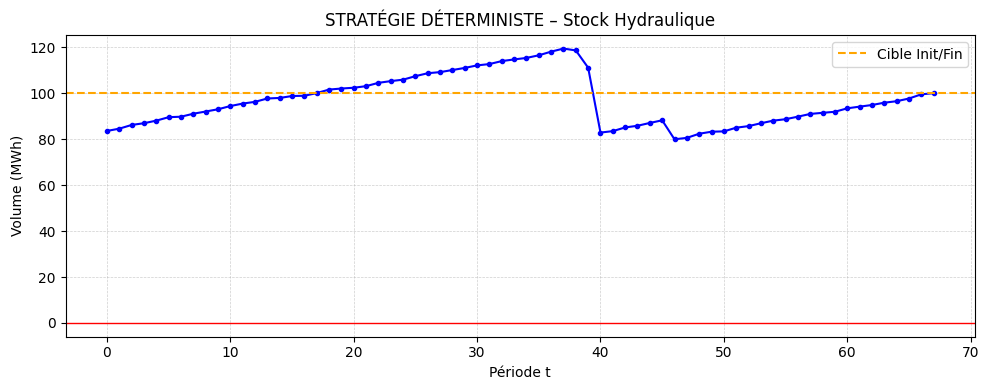


=================== STRATÉGIE STOCHASTIQUE ====================


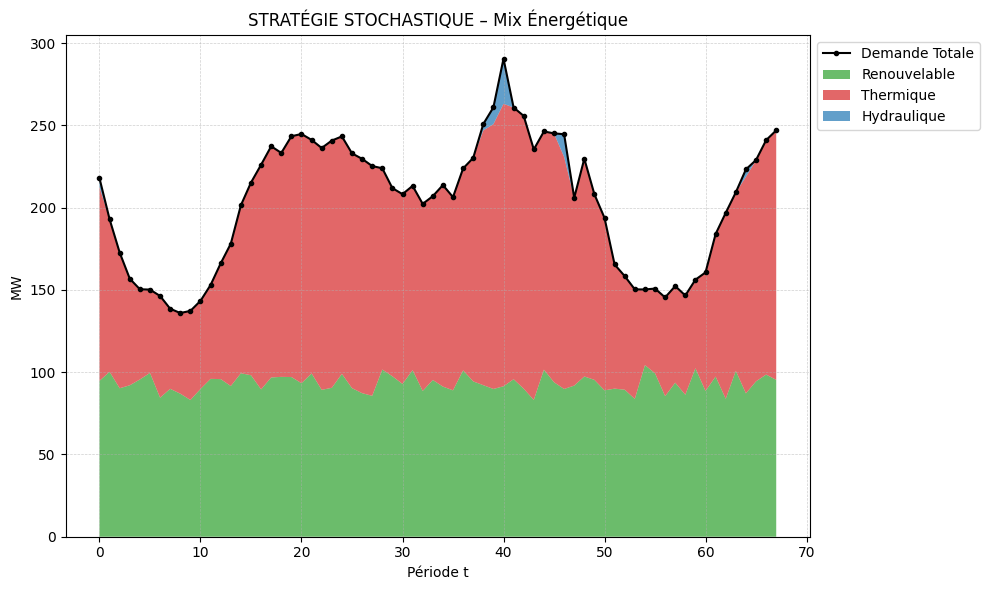

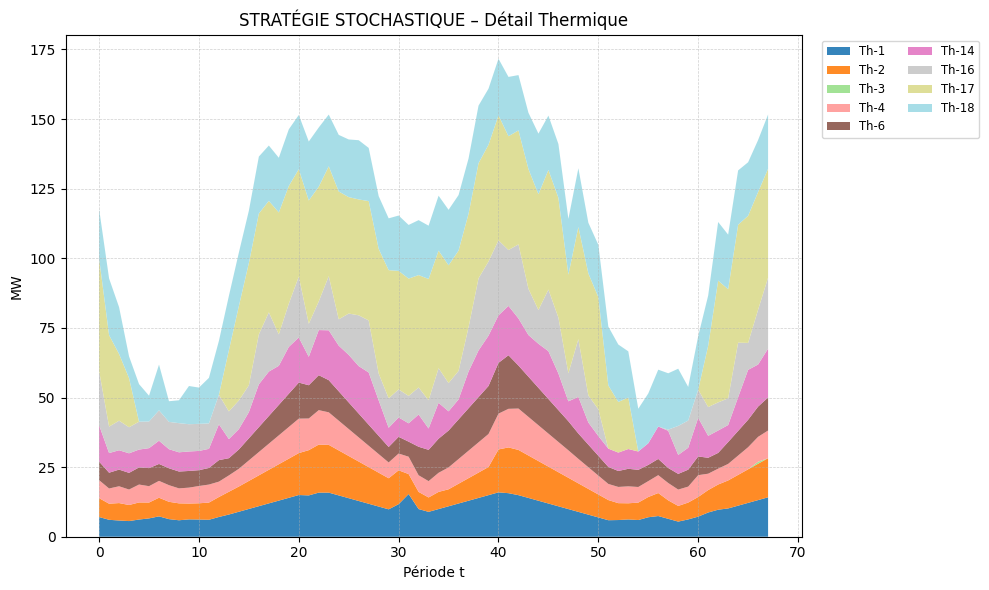

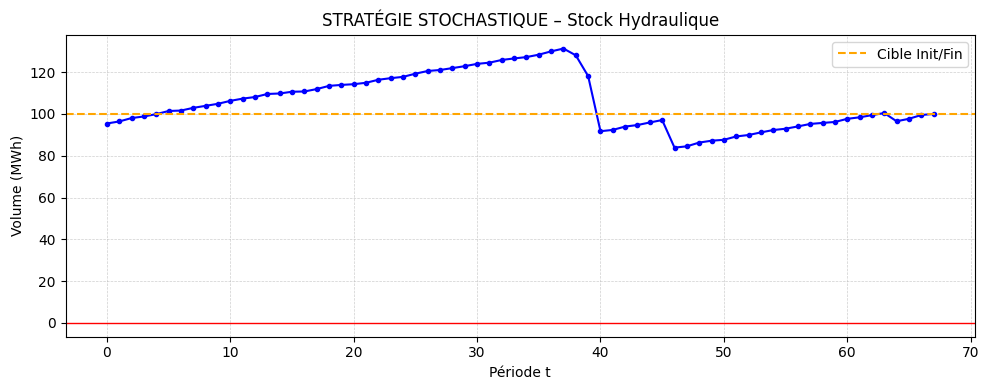

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpContinuous, value, PULP_CBC_CMD

# ==============================================================================
# 1. OUTIL DE SIMULATION (Basé sur votre evaluate_scenario)
# ==============================================================================
def solve_dispatch_viz_economic(u_fixed, Pmin_scen, Pmax_scen, demand_scen, inflows_scen, lamb):
    """
    Résout le dispatch (LP) en reprenant EXACTEMENT la logique de votre evaluate_scenario
    (Minimiser Coût + CO2 + Shed - Eau), mais renvoie les séries temporelles pour le plot.
    """
    m_eval = LpProblem("Eval_Dispatch_Viz", LpMinimize)
    
    # Variables Wait-and-See
    p_eval = {(j, t): LpVariable(f"p_{j}_{t}", lowBound=0, cat=LpContinuous) for j in range(G+GF) for t in range(T)}
    shed_eval = {t: LpVariable(f"shed_{t}", lowBound=0, cat=LpContinuous) for t in range(T)}
    
    # Hydraulique
    h_gen = {t: LpVariable(f"h_gen_{t}", lowBound=0, upBound=Hydro_Pmax, cat=LpContinuous) for t in range(T)}
    h_vol = {t: LpVariable(f"h_vol_{t}", lowBound=Hydro_Vmin, upBound=Hydro_Vmax, cat=LpContinuous) for t in range(T)}
    h_spill = {t: LpVariable(f"h_spill_{t}", lowBound=0, cat=LpContinuous) for t in range(T)}

    # --- Contraintes ---
    # 1. Bilan Hydraulique
    m_eval += h_vol[0] == Hydro_Vinit - h_gen[0] + inflows_scen[0] - h_spill[0]
    for t in range(1, T):
        m_eval += h_vol[t] == h_vol[t-1] - h_gen[t] + inflows_scen[t] - h_spill[t]
    m_eval += h_vol[T-1] >= Hydro_Vinit

    # 2. Équilibre Offre-Demande
    for t in range(T):
        # Note: On suppose ici que demand_scen est la DEMANDE TOTALE
        m_eval += lpSum(p_eval[(j, t)] for j in range(G+GF)) + h_gen[t] + shed_eval[t] == demand_scen[t]
        
        for j in range(G+GF):
            if j < G:
                status = u_fixed[(j, t)]
            else:
                status = 1.0 # ENR
            
            limit_min = Pmin_scen[j][t]
            limit_max = Pmax_scen[j][t]
            
            m_eval += p_eval[(j, t)] >= limit_min * status
            m_eval += p_eval[(j, t)] <= limit_max * status
            
            if j < G and t > 0:
                grad = Gradient_all[j]
                m_eval += p_eval[(j, t)] - p_eval[(j, t-1)] <= grad
                m_eval += p_eval[(j, t-1)] - p_eval[(j, t)] <= grad

    # --- Objectif ---
    BIG_SHED = 1e6
    var_cost = lpSum(Cout_all[j] * p_eval[(j, t)] for j in range(G+GF) for t in range(T))
    co2_load = lpSum(TauxCO2_all[j] * p_eval[(j, t)] for j in range(G+GF) for t in range(T))
    shed_cost = lpSum(BIG_SHED * shed_eval[t] for t in range(T))
    water_value = Hydro_Omega * h_vol[T-1]

    # Minimiser Coût Var + CO2 + Shed - Valeur Eau
    m_eval += var_cost + lamb * co2_load + shed_cost - water_value

    m_eval.solve(PULP_CBC_CMD(msg=False))
    
    # --- Extraction des Données pour le Plotting ---
    res = {
        'p': {(j, t): value(p_eval[(j, t)]) for j in range(G+GF) for t in range(T)},
        'shed': [value(shed_eval[t]) for t in range(T)],
        'h_gen': [value(h_gen[t]) for t in range(T)],
        'h_vol': [value(h_vol[t]) for t in range(T)],
        'demand': demand_scen
    }
    return res

# ==============================================================================
# 2. FONCTION DE PLOTTING (VOTRE STYLE EXACT)
# ==============================================================================
def plot_single_scenario_detailed(results, title_prefix):
    
    def _val(x): return 0.0 if x is None else float(x)
    
    print(f"\n=================== {title_prefix} ====================")

    # Extraction
    total_demand_series = results['demand']
    shed_series = [_val(x) for x in results['shed']]
    hydro_gen = [_val(x) for x in results['h_gen']]
    hydro_vol = [_val(x) for x in results['h_vol']]
    
    # Reconstitution des sommes
    renewable_gen = [sum(_val(results['p'][(j, t)]) for j in range(G, G + GF)) for t in range(T)]
    thermal_gen = [sum(_val(results['p'][(j, t)]) for j in range(G)) for t in range(T)]

    # --- PLOT A : MIX ÉNERGÉTIQUE ---
    total_stack_height = [r + th + h for r, th, h in zip(renewable_gen, thermal_gen, hydro_gen)]
    
    plt.figure(figsize=(10, 6))
    # 1. La Demande
    plt.plot(range(T), total_demand_series, marker='.', label='Demande Totale', color='black', linewidth=1.5, zorder=10)
    
    # 2. Le Stackplot
    plt.stackplot(range(T), renewable_gen, thermal_gen, hydro_gen, 
                  labels=['Renouvelable', 'Thermique', 'Hydraulique'], 
                  colors=['#2ca02c', '#d62728', '#1f77b4'], alpha=0.7)
    
    # 3. Le Délestage
    if sum(shed_series) > 0.1:
        plt.bar(range(T), shed_series, bottom=total_stack_height, alpha=0.4, label='Délestage', color='gray', hatch='//')

    plt.xlabel('Période t'); plt.ylabel('MW')
    plt.title(f'{title_prefix} – Mix Énergétique')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1))
    plt.tight_layout()
    plt.show()

    # --- PLOT B : DÉTAIL THERMIQUE ---
    # Création de la matrice thermique [Groupe][Temps]
    prod_mat = np.array([[results['p'][(g, t)] for t in range(T)] for g in range(G)])
    
    # On ne garde que les unités actives
    active_units = [g for g in range(G) if prod_mat[g].sum() > 1e-1]
    
    plt.figure(figsize=(10, 6))
    if active_units:
        # Couleurs distinctes
        colors = plt.cm.tab20(np.linspace(0, 1, len(active_units)))
        plt.stackplot(range(T), [prod_mat[g] for g in active_units], labels=[f"Th-{g}" for g in active_units], colors=colors, alpha=0.9)
    else:
        plt.text(0.5, 0.5, "Aucun Thermique Allumé", ha='center')

    plt.xlabel('Période t'); plt.ylabel('MW')
    plt.title(f'{title_prefix} – Détail Thermique')
    if active_units: plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize='small', ncol=2)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # --- PLOT C : STOCK HYDRO ---
    plt.figure(figsize=(10, 4))
    plt.plot(range(T), hydro_vol, marker='.', linestyle='-', color='blue')
    plt.axhline(Hydro_Vinit, color='orange', linestyle='--', label='Cible Init/Fin')
    plt.axhline(0, color='red', linewidth=1)
    
    plt.xlabel('Période t'); plt.ylabel('Volume (MWh)')
    plt.title(f'{title_prefix} – Stock Hydraulique')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==============================================================================
# 3. EXÉCUTION (Step-by-Step)
# ==============================================================================

LAMBDA_SIMU = 0.5
S_STOCH = 5

# A. Calcul des Stratégies
print(">>> 1. Calcul Stratégie DÉTERMINISTE (Moyenne)...", end="")
Pmin_d, Pmax_d, dem_d, infl_d = generate_deterministic_data_hydro()
# Note : on met des '_' car fonction renvoie 8 valeurs
md, ud_raw, vd, wd, _, _, _, _ = stochastic_model_with_hydro(LAMBDA_SIMU, 1, Pmin_d, Pmax_d, dem_d, infl_d)
md.solve(PULP_CBC_CMD(msg=False))
u_det, _, _ = extract_strategy(ud_raw, vd, wd)
print(" Ok.")

print(f">>> 2. Calcul Stratégie STOCHASTIQUE ({S_STOCH} scénarios)...", end="")
Pmin_s, Pmax_s, dem_s, infl_s = generate_scenarios(S_STOCH)
ms, us_raw, vs, ws, _, _, _, _ = stochastic_model_with_hydro(LAMBDA_SIMU, S_STOCH, Pmin_s, Pmax_s, dem_s, infl_s)
ms.solve(PULP_CBC_CMD(msg=False))
u_sto, _, _ = extract_strategy(us_raw, vs, ws)
print(" Ok.")

# B. Tirage du scénario de test
print(">>> 3. Tirage d'un scénario de test (Mode NORMAL)...")
# On tire le scénario qui sera le juge de paix
pm_test, pM_test, d_test, infl_test = generate_single_scenario(mode='normal')

# C. Simulation du Dispatch Économique
print(">>> 4. Simulation du Dispatch Économique...")
res_det = solve_dispatch_viz_economic(u_det, pm_test, pM_test, d_test, infl_test, LAMBDA_SIMU)
res_sto = solve_dispatch_viz_economic(u_sto, pm_test, pM_test, d_test, infl_test, LAMBDA_SIMU)

# D. Affichage
plot_single_scenario_detailed(res_det, title_prefix="STRATÉGIE DÉTERMINISTE")
plot_single_scenario_detailed(res_sto, title_prefix="STRATÉGIE STOCHASTIQUE")

## Front de pareto stochastique

On calcule ici la **frontière de Pareto** entre coût économique et émissions de CO$_2$ en faisant varier le paramètre de pondération $\lambda$ dans la fonction objectif. Pour chaque valeur de $\lambda$ :
- on résout le modèle stochastique avec hydraulique sur un jeu de scénarios fixe,
- on extrait le coût total net (incluant la valeur de l'eau),
- on calcule les émissions de CO$_2$ agrégées.

Les points obtenus sont ensuite représentés sur un graphe coût/CO$_2$ annoté par les valeurs de $\lambda$.

--> Génération du jeu de données fixe (3 scénarios avec Hydro)...
--> Calcul de la frontière (10 points)...
  Lambda=  0 | Coût Net=593,428 € | CO2=2,529,011.11 t
  Lambda=0.1 | Coût Net=596,117 € | CO2=2,478,613.46 t
  Lambda=0.2 | Coût Net=607,789 € | CO2=2,407,317.52 t
  Lambda=0.3 | Coût Net=652,200 € | CO2=2,231,067.50 t
  Lambda=0.4 | Coût Net=715,005 € | CO2=2,059,814.89 t
  Lambda=0.45 | Coût Net=791,702 € | CO2=1,879,583.16 t
  Lambda=0.5 | Coût Net=800,906 € | CO2=1,860,467.66 t
  Lambda=0.6 | Coût Net=899,565 € | CO2=1,667,519.32 t
  Lambda=  1 | Coût Net=916,410 € | CO2=1,647,663.91 t
  Lambda=  5 | Coût Net=923,896 € | CO2=1,640,966.61 t


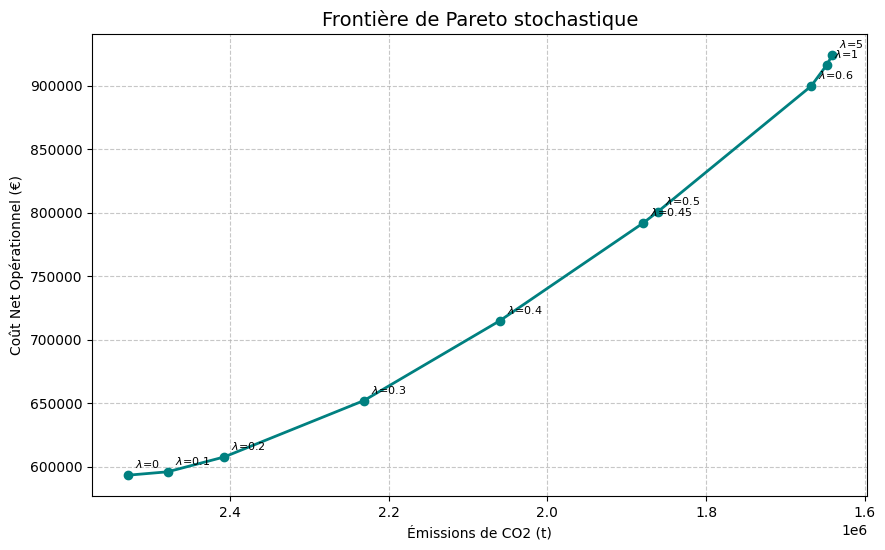

In [16]:
import matplotlib.pyplot as plt
from pulp import value, lpSum, CPLEX_CMD

def plot_pareto_frontier_cplex_hydro(S_train=5):
    """
    Trace le front de Pareto (Coût vs CO2) avec le modèle HYDRAULIQUE.
    """
    lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 1, 5]
    pareto_costs = [] 
    pareto_co2 = []   
    
    # A. Génération des scénarios FIXES (incluant inflows)
    print(f"--> Génération du jeu de données fixe ({S_train} scénarios avec Hydro)...")
    Pmin_f, Pmax_f, dem_f, infl_f = generate_scenarios(S_train)
    
    print(f"--> Calcul de la frontière ({len(lambda_values)} points)...")

    for lamb in lambda_values:
        # B. Résolution Modèle Hydro
        model, u, v, w, p, shed, h_gen, h_vol = stochastic_model_with_hydro(
            lamb, S_train, Pmin_f, Pmax_f, dem_f, infl_f
        )
        model.solve(CPLEX_CMD(msg=False))
        
        # C. Extraction Moyennes
        cost_start = value(lpSum(CoutDemarrage_all[j] * v[(j, t)] for j in range(G+GF) for t in range(T)))
        
        cost_var_avg = value(lpSum(Cout_all[j] * p[(j, t, s)] 
                                   for j in range(G+GF) for t in range(T) for s in range(S_train))) / S_train
        
        cost_shed_avg = value(lpSum(1e6 * shed[(t, s)] 
                                    for t in range(T) for s in range(S_train))) / S_train
        
        # Gain Eau (à soustraire du coût)
        gain_water_avg = value(lpSum(Hydro_Omega * h_vol[(T-1, s)] for s in range(S_train))) / S_train
        
        # Coût Total Net
        total_eur = cost_start + cost_var_avg + cost_shed_avg - gain_water_avg
        
        # CO2 Total
        total_co2 = value(lpSum(TauxCO2_all[j] * p[(j, t, s)] 
                                for j in range(G+GF) for t in range(T) for s in range(S_train))) / S_train
        
        pareto_costs.append(total_eur)
        pareto_co2.append(total_co2)
        
        print(f"  Lambda={lamb:3} | Coût Net={total_eur:,.0f} € | CO2={total_co2:,.2f} t")

    # D. Plot
    plt.figure(figsize=(10, 6))
    plt.plot(pareto_co2, pareto_costs, 'o-', color='teal', linewidth=2, label='Avec Hydraulique')
    
    for i, txt in enumerate(lambda_values):
        plt.annotate(f"$\lambda$={txt}", (pareto_co2[i], pareto_costs[i]), 
                     xytext=(5, 5), textcoords='offset points', fontsize=8)

    plt.title(f"Frontière de Pareto stochastique", fontsize=14)
    plt.xlabel("Émissions de CO2 (t)")
    plt.ylabel("Coût Net Opérationnel (€)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().invert_xaxis()
    plt.show()

plot_pareto_frontier_cplex_hydro(S_train=3)

## Comparaison stochastique vs déterministe sur un nouveau scénario tiré

Cette section met en place un **comparatif moyen** entre :
- une stratégie déterministe construite sur le scénario moyen,
- une stratégie stochastique entraînée sur plusieurs scénarios.

Les deux stratégies sont ensuite évaluées sur un ensemble de scénarios de test (souvent en mode `stress`) et on compare :
- le coût total moyen,
- les émissions moyennes de CO$_2$,
- la fréquence de délestage. 

In [ ]:
# =========================================================
# Fonction pour générer les données DÉTERMINISTES avec Hydro
# =========================================================
def generate_deterministic_data_hydro():
    """
    S=1, tout à la moyenne (y compris Inflows).
    Adaptation : Génère des LISTES pour Pmin/Pmax (profils plats à la moyenne).
    """
    Pmin_d = [[None for _ in range(G+GF)]]
    Pmax_d = [[None for _ in range(G+GF)]]
    dem_d = [[0]*T]
    infl_d = [[0]*T]
    
    # 1. Offre (Thermique + Renouvelable) à la moyenne
    for j in range(G + GF):
        
        # Récupération de la moyenne (mu)
        if j < G:
            mu = gamma_therm[j]['mu']
        else:
            idx = j - G
            mu = gamma_renew[idx]['mu']
            
        # Calcul des valeurs moyennes (Scalaires)
        val_min = Pmin_all[j] * mu
        val_max = Pmax_all[j] * mu
        
        # Si renouvelable, Pmin = 0
        if j >= G:
            val_min = 0.0
            
        Pmin_d[0][j] = [val_min] * T
        Pmax_d[0][j] = [val_max] * T

    # 2. Demande & Inflows à la moyenne
    for t in range(T):
        dem_d[0][t] = demand_distrib[t]['mu']
        infl_d[0][t] = Mu_Inflow # Valeur moyenne constante
        
    return Pmin_d, Pmax_d, dem_d, infl_d

import numpy as np

# ==========================================================
# Fonction Principale (Nettoyée et Mode Stress activé)
# ==========================================================
def run_comparison_vss_hydro_average(lamb=0.5, S_stoch=30, n_test=10):
    """
    Compare les stratégies Déterministe et Stochastique sur la moyenne de n_test scénarios.
    VERSION NETTOYÉE : Pas de graphiques.
    MODE : Stress Test activé par défaut dans la boucle.
    """
    print(f"\n=== COMPARATIF HYDRO (Moyenne sur {n_test} scénarios STRESS) : Lambda={lamb} ===")

    # ---------------------------------------------------------
    # 1. Résolution des modèles (Phase d'apprentissage - Planification)
    # ---------------------------------------------------------

    # A. Stratégie DÉTERMINISTE
    print("1. Calcul de la Stratégie Déterministe (sur la Moyenne)...", end=" ")
    Pmin_d, Pmax_d, dem_d, infl_d = generate_deterministic_data_hydro()
    
    # Résolution (S=1)
    md, ud, vd, wd, pd, sd, hd, hvd = stochastic_model_with_hydro(lamb, 1, Pmin_d, Pmax_d, dem_d, infl_d)
    md.solve(CPLEX_CMD(msg=False))
    u_det, v_det, w_det = extract_strategy(ud, vd, wd)
    print("Ok.")

    # B. Stratégie STOCHASTIQUE
    print(f"2. Calcul de la Stratégie Stochastique ({S_stoch} scénarios)...", end=" ")
    Pmin_s, Pmax_s, dem_s, infl_s = generate_scenarios(S_stoch)
    
    # Résolution (S=S_stoch)
    ms, us, vs, ws, ps, ss, hs, hvs = stochastic_model_with_hydro(lamb, S_stoch, Pmin_s, Pmax_s, dem_s, infl_s)
    ms.solve(CPLEX_CMD(msg=False))
    u_sto, v_sto, w_sto = extract_strategy(us, vs, ws)
    print("Ok.")

    # ---------------------------------------------------------
    # 2. Évaluation (Phase de Test / Out-of-Sample)
    # ---------------------------------------------------------
    print(f"3. CRASH TEST sur {n_test} scénarios 'STRESS'...")

    results_D = {'cost': [], 'co2': [], 'shed': []}
    results_S = {'cost': [], 'co2': [], 'shed': []}

    for i in range(n_test):
        # pour voir si le déterministe craque.
        pm_t, pM_t, d_t, infl_t = generate_single_scenario(mode='stress') 

        # Évaluation DÉTERMINISTE
        c_D, co2_D, s_D = evaluate_scenario(u_det, v_det, w_det, pm_t, pM_t, d_t, infl_t, lamb)
        results_D['cost'].append(c_D)
        results_D['co2'].append(co2_D)
        results_D['shed'].append(1 if s_D else 0)

        # Évaluation STOCHASTIQUE
        c_S, co2_S, s_S = evaluate_scenario(u_sto, v_sto, w_sto, pm_t, pM_t, d_t, infl_t, lamb)
        results_S['cost'].append(c_S)
        results_S['co2'].append(co2_S)
        results_S['shed'].append(1 if s_S else 0)

    # ---------------------------------------------------------
    # 3. Calcul des Moyennes et Affichage
    # ---------------------------------------------------------
    avg_cost_D = np.mean(results_D['cost'])
    avg_cost_S = np.mean(results_S['cost'])
    gain = avg_cost_D - avg_cost_S 

    avg_co2_D = np.mean(results_D['co2'])
    avg_co2_S = np.mean(results_S['co2'])

    freq_shed_D = np.mean(results_D['shed']) * 100 
    freq_shed_S = np.mean(results_S['shed']) * 100

    print("\n" + "="*85)
    print(f"{'INDICATEUR (Moyenne)':<25} | {'DÉTERMINISTE':<15} | {'STOCHASTIQUE':<15} | {'GAIN (VSS)':<15}")
    print("="*85)
    print(f"{'Coût Total (€)':<25} | {avg_cost_D:,.0f} €{' ':<7} | {avg_cost_S:,.0f} €{' ':<7} | {gain:+,.0f} €")
    print(f"{'Émissions CO2 (t)':<25} | {avg_co2_D:,.1f} t{' ':<8} | {avg_co2_S:,.1f} t{' ':<8} | {avg_co2_D - avg_co2_S:+,.1f} t")
    print(f"{'Fréquence Délestage':<25} | {freq_shed_D:.1f} %{' ':<9} | {freq_shed_S:.1f} %{' ':<9} | {freq_shed_D - freq_shed_S:+.1f} pts")
    print("-" * 85)

    if gain > 0:
        print(f"VICTOIRE : Le stochastique gagne grâce à sa robustesse face au stress.")
    elif freq_shed_D == 0:
        print(f"ÉCHEC DU TEST : Toujours pas de délestage sur le déterministe.")
        print("Conseil : Dans 'generate_single_scenario', pour le mode 'stress', réduisez drastiquement le vent (x 0.1) !")

# Lancement
run_comparison_vss_hydro_average(lamb=0.5, S_stoch=30, n_test=10)


=== COMPARATIF HYDRO (Moyenne sur 10 scénarios STRESS) : Lambda=0.5 ===
1. Calcul de la Stratégie Déterministe (sur la Moyenne)... Ok.
2. Calcul de la Stratégie Stochastique (30 scénarios)... Ok.
3. CRASH TEST sur 10 scénarios 'STRESS'...

INDICATEUR (Moyenne)      | DÉTERMINISTE    | STOCHASTIQUE    | GAIN (VSS)     
Coût Total (€)            | 812,269 €        | 828,810 €        | -16,541 €
Émissions CO2 (t)         | 1,808,021.2 t         | 1,799,055.1 t         | +8,966.1 t
Fréquence Délestage       | 0.0 %          | 0.0 %          | +0.0 pts
-------------------------------------------------------------------------------------
ÉCHEC DU TEST : Toujours pas de délestage sur le déterministe.
Conseil : Dans 'generate_single_scenario', pour le mode 'stress', réduisez drastiquement le vent (x 0.1) !


### Plotting

Cette dernière partie propose des **visualisations détaillées** de quelques scénarios :
- mix énergétique (thermique, renouvelable, hydraulique) par pas de temps,
- détail de la production thermique par unité active,
- évolution du stock hydraulique.

Ces figures illustrent concrètement le comportement des stratégies obtenues et facilitent l'interprétation des résultats numériques.

Scénarios affichés : [0, 1, 2]

=================== SCENARIO 0 ====================


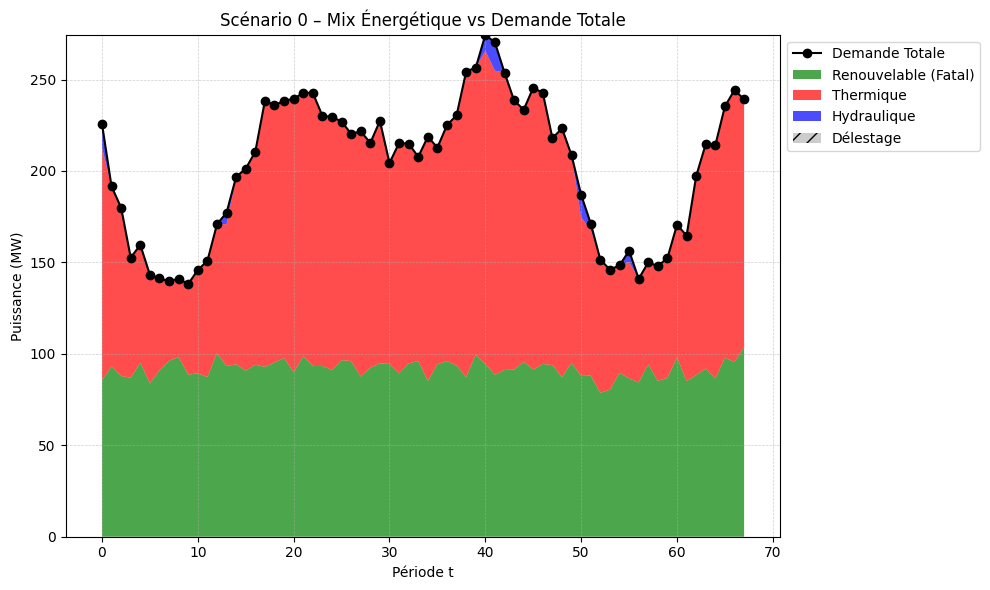

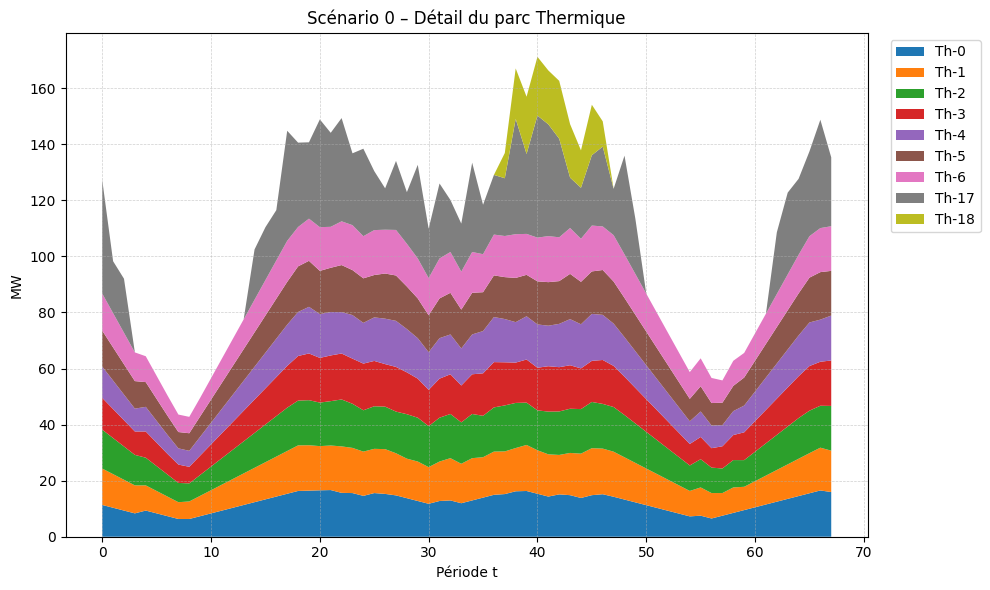

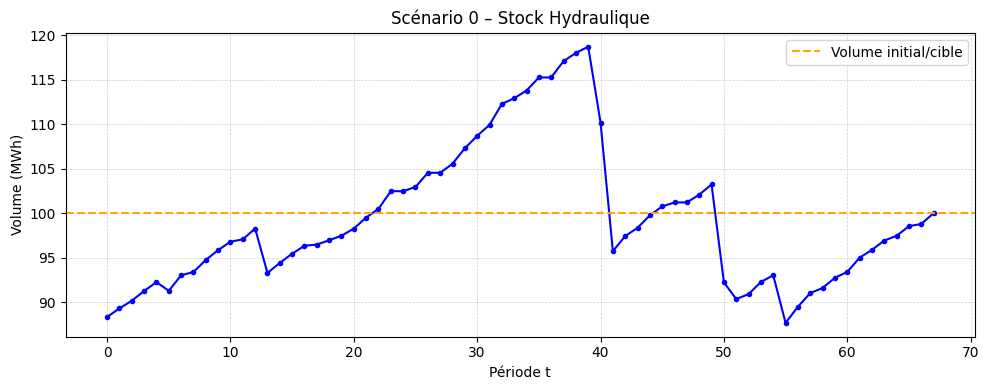


=================== SCENARIO 1 ====================


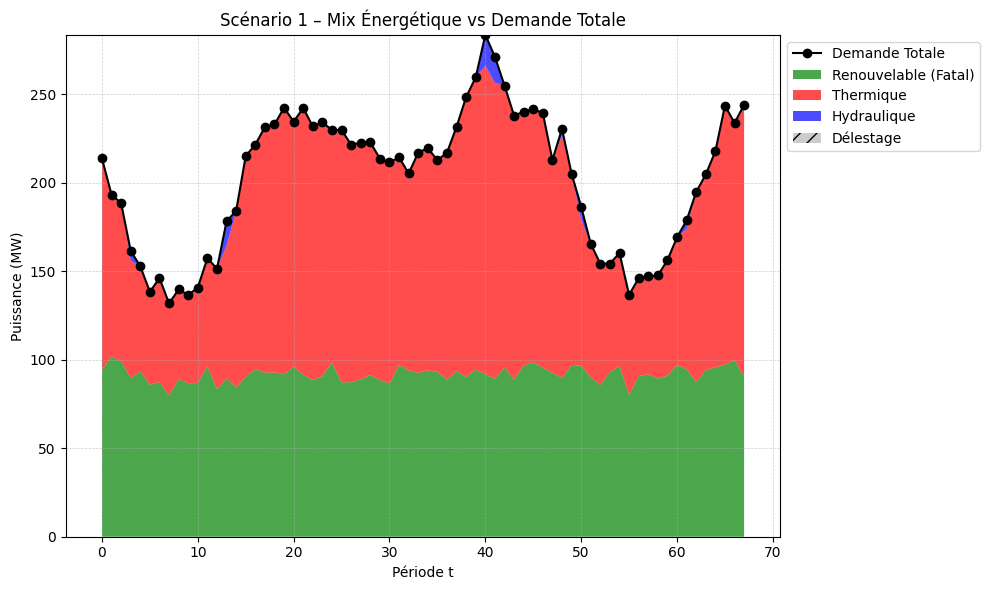

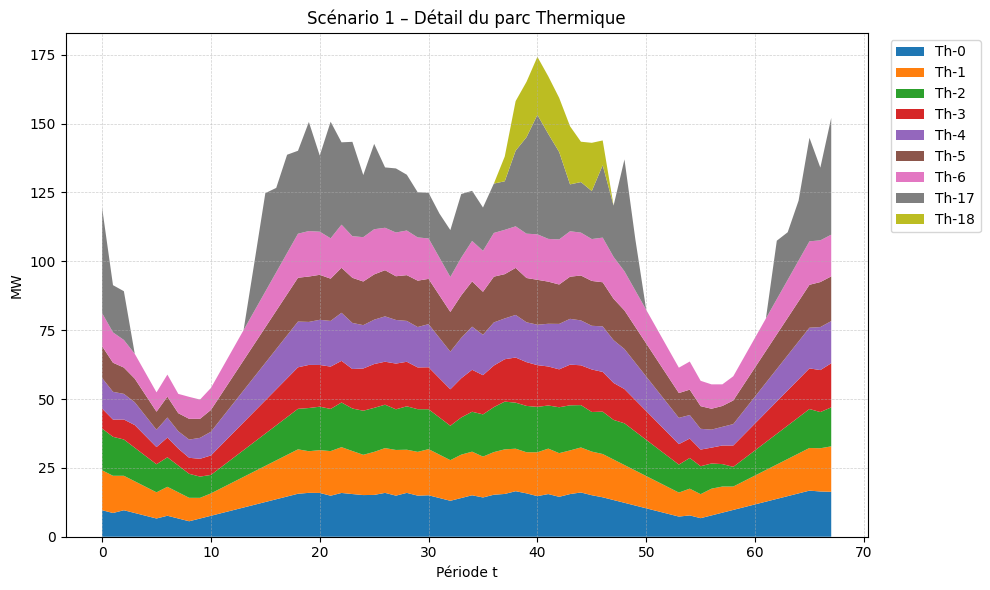

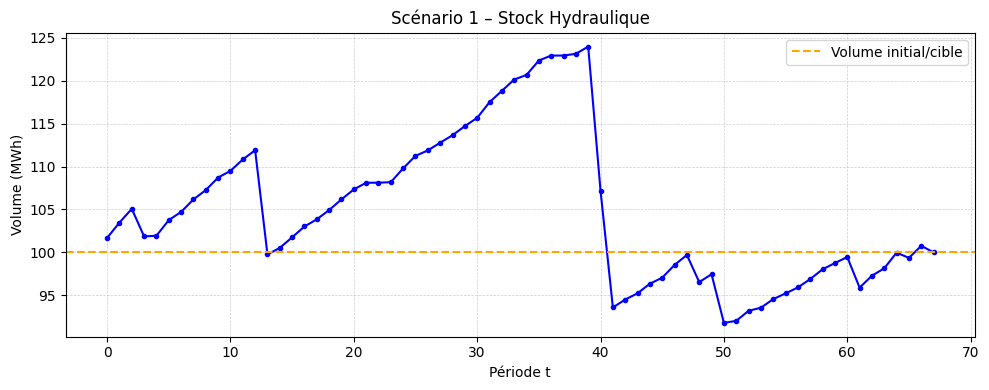


=================== SCENARIO 2 ====================


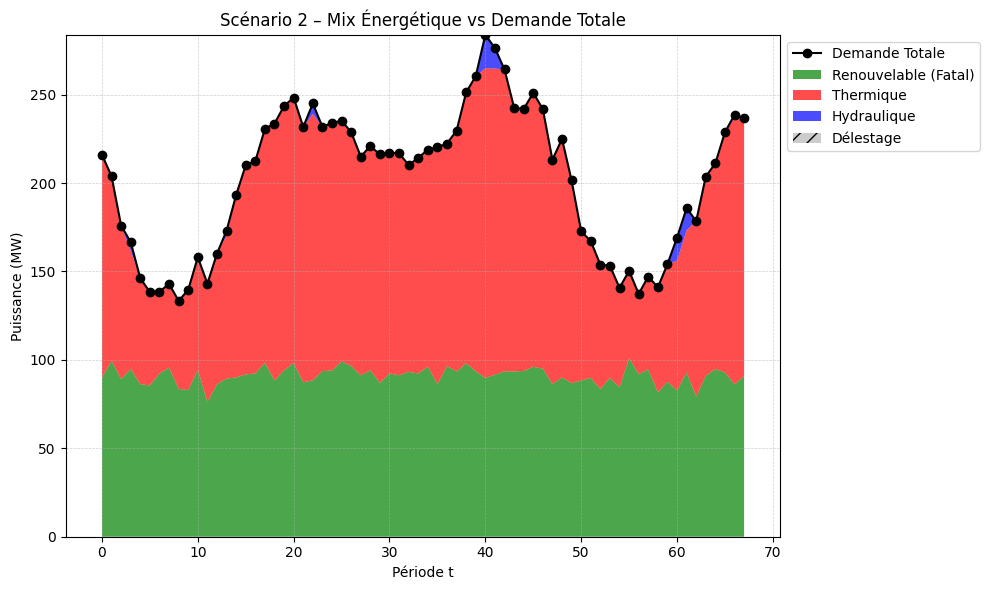

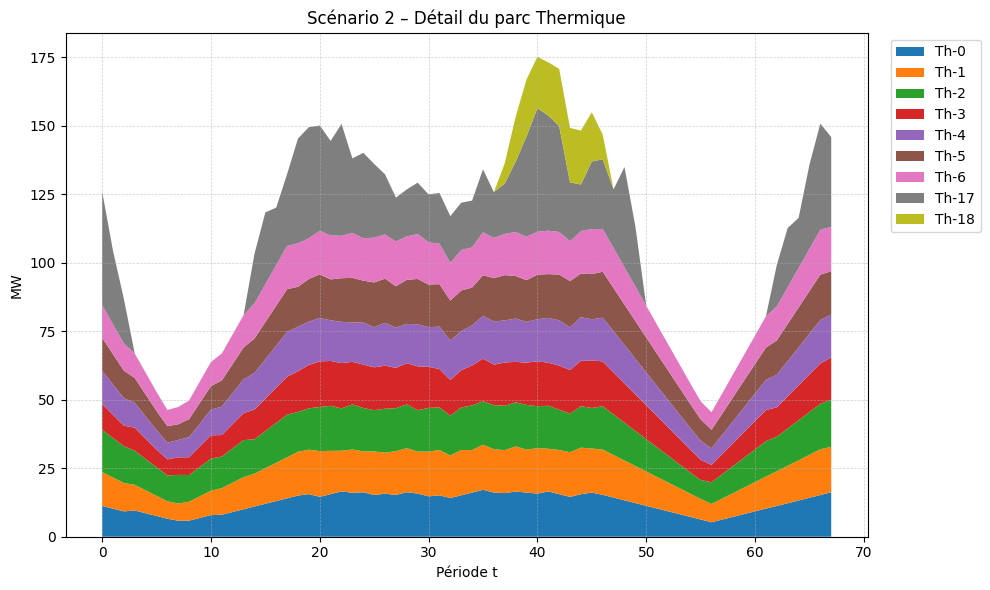

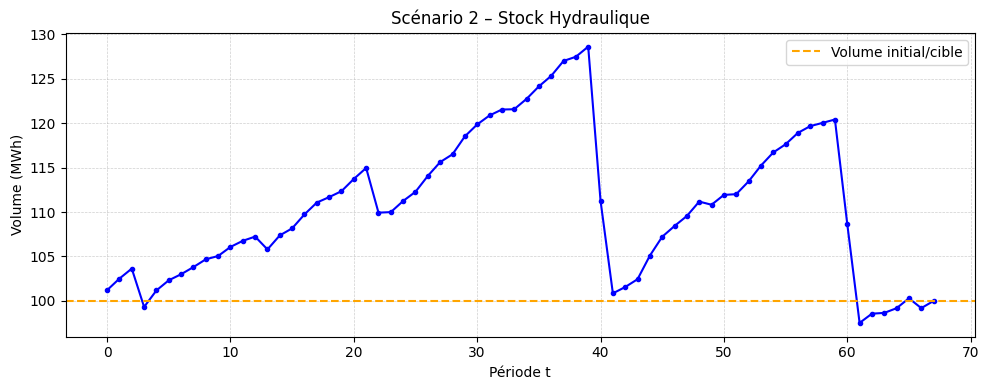

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pulp import value

# --- PARAMÈTRES ---
scenarios_to_plot = [0, 1, 2]
print("Scénarios affichés :", scenarios_to_plot)

def _val(x):
    return 0.0 if x is None else float(x)

# =====================================================
# ===============  PLOTS MULTI-SCÉNARIOS  =============
# =====================================================

for s in scenarios_to_plot:
    print(f"\n=================== SCENARIO {s} ====================")

    # --- 1. Extraction des séries temporelles ---
    
    # a) Demande Totale (Directement depuis les données)
    total_demand_series = demand_s[s]

    # b) Production Renouvelable
    renewable_gen = [
        sum(_val(p_stoch[(j, t, s)].value()) for j in range(G, G + GF))
        for t in range(T)
    ]

    # c) Production Thermique
    thermal_gen = [
        sum(_val(p_stoch[(j, t, s)].value()) for j in range(G))
        for t in range(T)
    ]

    # d) Production Hydraulique
    hydro_gen = [
        _val(h_gen_stoch[(t, s)].value())
        for t in range(T)
    ]
    
    # e) Délestage et Volume
    shed_series = [_val(shed_stoch[(t, s)].value()) for t in range(T)]
    hydro_vol = [_val(h_vol_stoch[(t, s)].value()) for t in range(T)]

    # =================== PLOT A =======================
    # Bilan : Demande Totale vs Empilement (EnR + Therm + Hydro)
    
    # Calcul de la hauteur totale de la pile pour placer le délestage au-dessus
    total_stack_height = [r + th + h for r, th, h in zip(renewable_gen, thermal_gen, hydro_gen)]
    
    plt.figure(figsize=(10, 6))
    
    # 1. La cible : Demande Totale (Ligne Noire)
    plt.plot(range(T), total_demand_series, marker='o', label='Demande Totale', color='black', linewidth=1.5, zorder=10)
    
    # 2. Le Stackplot (Merit Order classique : EnR en bas, puis Thermique, puis Hydro)
    plt.stackplot(
        range(T), 
        renewable_gen, 
        thermal_gen, 
        hydro_gen,
        labels=['Renouvelable (Fatal)', 'Thermique', 'Hydraulique'], 
        colors=['green', 'red', 'blue'], 
        alpha=0.7
    )
    
    # 3. Le Délestage (au-dessus du tout)
    plt.bar(range(T), shed_series, bottom=total_stack_height, alpha=0.4, label='Délestage', color='gray', hatch='//')

    plt.xlabel('Période t')
    plt.ylabel('Puissance (MW)')
    plt.title(f'Scénario {s} – Mix Énergétique vs Demande Totale')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1)) 
    plt.tight_layout()
    plt.show()

    # =================== PLOT B (Thermique détaillé) =======================
    prod_mat = np.array([
        [ _val(p_stoch[(g, t, s)].value()) for t in range(T)]
        for g in range(G)
    ])
    active_units = [g for g in range(G) if prod_mat[g].sum() > 1e-9]
    if not active_units: active_units = list(range(G))

    plt.figure(figsize=(10, 6))
    plt.stackplot(
        range(T),
        [prod_mat[g] for g in active_units],
        labels=[f"Th-{g}" for g in active_units]
    )
    plt.xlabel('Période t')
    plt.ylabel('MW')
    plt.title(f'Scénario {s} – Détail du parc Thermique')
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # =================== PLOT C (Volume Hydro) =======================
    plt.figure(figsize=(10, 4))
    plt.plot(range(T), hydro_vol, marker='.', linestyle='-', color='blue')
    
    try:
        if 'Hydro_Vinit' in globals():
             plt.axhline(Hydro_Vinit, color='orange', linestyle='--', label='Volume initial/cible')
    except NameError: pass

    plt.xlabel('Période t')
    plt.ylabel('Volume (MWh)')
    plt.title(f'Scénario {s} – Stock Hydraulique')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Sensibilité avec S 

In [ ]:
import time
import matplotlib.pyplot as plt
from pulp import PULP_CBC_CMD

def analyze_sample_size_sensitivity_hydro_OOS(S_values, lamb_fixed=50, N_TEST=10):
    """
    Analyse l'impact de la taille de l'échantillon S sur la performance réelle (Out-of-Sample).
    Utilise 'extract_strategy' pour récupérer les variables binaires.
    """
    results_avg_cost = []
    results_time = []
    
    print(f"--- Analyse de sensibilité sur S (Out-of-Sample, N_TEST={N_TEST}) ---")
    
    # --- Étape 0 : Génération des Scénarios de TEST (Jeu de données fixe) ---
    # Ces données servent de référence unique pour comparer tous les modèles
    print(f"Génération du jeu de test de {N_TEST} scénarios...", end=" ")
    Pmin_test, Pmax_test, dem_test, infl_test = generate_scenarios(N_TEST)
    print("OK.\n")
    
    for S in S_values:
        print(f"Entraînement avec S = {S} ... ", end="")
        
        # --- Étape 1 : Génération des données d'ENTRAÎNEMENT ---
        Pmin_train, Pmax_train, dem_train, infl_train = generate_scenarios(S)
        
        # --- Étape 2 : Optimisation (Training) ---
        start_time = time.time()
        
        # Création et résolution du modèle stochastique principal
        model, u_vars, v_vars, w_vars, p, shed, h_g, h_v = stochastic_model_with_hydro(
            lamb_fixed, S, Pmin_train, Pmax_train, dem_train, infl_train
        )
        
        # Résolution (Time limit ajusté selon la difficulté)
        model.solve(PULP_CBC_CMD(msg=False, timeLimit=180))
        
        elapsed = time.time() - start_time
        results_time.append(elapsed)
        
        # --- Étape 3 : Extraction de la stratégie (Unit Commitment) ---
        u_fixed, v_fixed, w_fixed = extract_strategy(u_vars, v_vars, w_vars)

        # --- Étape 4 : Évaluation sur le jeu de TEST (Testing) ---
        # On teste la robustesse de la stratégie u_fixed sur des scénarios inconnus
        total_test_cost = 0
        
        for k in range(N_TEST):
            # Données du k-ième scénario de test
            pmin_k = Pmin_test[k]
            pmax_k = Pmax_test[k]
            dem_k = dem_test[k]
            infl_k = infl_test[k]
            
            # Appel de la fonction d'évaluation (Dispatch LP)
            fin_cost, co2_val, has_shed = evaluate_scenario(
                u_fixed, v_fixed, w_fixed, 
                pmin_k, pmax_k, dem_k, infl_k, 
                lamb_fixed
            )
            
            # Calcul du coût généralisé (Obj = Cash + Lambda * CO2)
            scenario_obj = fin_cost + lamb_fixed * co2_val
            total_test_cost += scenario_obj
            
        # Moyenne sur les scénarios de test
        avg_cost_S = total_test_cost / N_TEST
        results_avg_cost.append(avg_cost_S)
        
        print(f"Time: {elapsed:.2f}s | Coût Moyen Test: {avg_cost_S:,.0f} €")

    return results_avg_cost, results_time

# --- Exécution ---
# Liste des tailles d'échantillons à tester
S_list = [3, 5, 10, 20, 30, 40, 50, 100, 200] 

# Appel de la fonction
objs_oos, times_oos = analyze_sample_size_sensitivity_hydro_OOS(S_list, lamb_fixed=50, N_TEST=10)

# --- Tracé des Graphiques ---
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Nombre de Scénarios d\'entraînement (S)')
ax1.set_ylabel("Coût Moyen sur Test (€)", color=color)
ax1.plot(S_list, objs_oos, 'o-', color=color, linewidth=2, label="Coût Out-of-Sample")
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Temps de Calcul Entraînement (s)', color=color)
ax2.plot(S_list, times_oos, 's--', color=color, linewidth=2, label="Temps de calcul")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Convergence Out-of-Sample : Modèle Stochastique avec Hydraulique")
plt.tight_layout()
plt.show()

--- Analyse de sensibilité sur S (Out-of-Sample, N_TEST=10) ---
Génération du jeu de test de 10 scénarios... OK.

Entraînement avec S = 3 ... Time: 41.90s | Coût Moyen Test: 82,761,238 €
Entraînement avec S = 5 ... Time: 73.72s | Coût Moyen Test: 82,440,906 €
Entraînement avec S = 10 ... Time: 147.68s | Coût Moyen Test: 86,177,903 €
Entraînement avec S = 20 ... 

# Version non stochastique

### Définition du modèle cplex

In [ ]:
def model(lamb):

    # =======================
    # Model
    # =======================
    m = LpProblem("UnitCommitment_with_Fatal", LpMinimize)

    # Decision variables, (ens sur lequel on va minimiser)
    u = {(g, t): LpVariable(f"u_{g}_{t}", cat=LpBinary) for g in range(G) for t in range(T)} #variable d'état (ON/OFF)
    v = {(g, t): LpVariable(f"v_{g}_{t}", cat=LpBinary) for g in range(G) for t in range(T)} #variable de démarrage (vaut 1 si g démarre à t)
    w = {(g, t): LpVariable(f"w_{g}_{t}", cat=LpBinary) for g in range(G) for t in range(T)} #variable d'arrêt (vaut 1 si g stop à t)
    p = {(g, t): LpVariable(f"p_{g}_{t}", lowBound=0, cat=LpContinuous) for g in range(G) for t in range(T)} #variable continue donnant la puissance
    # produite par g à t. 0 si u = 0, entre Pmin et Pmax sinon.

    # System-level helpers
    shed = {t: LpVariable(f"shed_{t}", lowBound=0, cat=LpContinuous) for t in range(T)}  #= qté d'énergie non fournie. continue positive. 
    # ajouté à la fonction objectif comme une pénalité, avec un coeff plus ou moins grand.
    curt = {(f, t): LpVariable(f"curt_{f}_{t}", lowBound=0, cat=LpContinuous) for f in range(GF) for t in range(T)}  # production renouvelable qu'on a produite mais dont 
    #on ne se sert pas car pas besoin/pas rentable. ( = écrêtement). peu/pas pénalisé


    # Constraints
    for g in range(G):
        Pmin = PminTechniqueThermique[g]
        Pmax = PmaxTechniqueThermique[g]
        for t in range(T):
            m += p[(g, t)] >= Pmin * u[(g, t)], f"min_output_g{g}_t{t}" # += est la syntaxe pour ajouter des contraintes au modèle m
            m += p[(g, t)] <= Pmax * u[(g, t)], f"max_output_g{g}_t{t}" #pour assurer que la prod p est entre pmin et pmax si u = 1

    for g in range(G):
        m += u[(g, 0)] - EtatInitialThermique[g] == v[(g, 0)] - w[(g, 0)], f"logic_init_g{g}"
        for t in range(1, T):
            m += u[(g, t)] - u[(g, t - 1)] == v[(g, t)] - w[(g, t)], f"logic_g{g}_t{t}" #contraintes logiques entre u, v et w.

    for g in range(G):
        L_up = DureeMinMarcheThermiquePdt[g]
        L_dn = DureeMinArretThermiquePdt[g]
        if L_up > 0:
            for t in range(T):
                start_window = range(max(0, t - L_up + 1), t + 1)
                m += lpSum(v[(g, k)] for k in start_window) <= u[(g, t)], f"min_up_g{g}_t{t}"
        if L_dn > 0:
            for t in range(T):
                shut_window = range(max(0, t - L_dn + 1), t + 1)
                m += lpSum(w[(g, k)] for k in shut_window) <= 1 - u[(g, t)], f"min_down_g{g}_t{t}" #contraintes de durée minimale de marche/arrêt

    for g in range(G):
        d_init = DureeEtatInitialThermiquePdt[g]
        if EtatInitialThermique[g] == 1:
            L_up = DureeMinMarcheThermiquePdt[g]
            rem = max(0, L_up - d_init)
            for t in range(min(rem, T)):
                m += u[(g, t)] == 1, f"force_up_initial_g{g}_t{t}" 
        else:
            L_dn = DureeMinArretThermiquePdt[g]
            rem = max(0, L_dn - d_init)
            for t in range(min(rem, T)):
                m += u[(g, t)] == 0, f"force_down_initial_g{g}_t{t}" #contrainte sur l'état initial

    #Grad constraints
    for g in range(G):
        grad_max = GradientThermiqueParPasDeTemps[g]
        print(grad_max)
        for t in range(1, T):
            m += p[(g, t)] - p[(g, t-1)] <= grad_max, f"grad_up_g{g}_t{t}"
            m += p[(g, t-1)] - p[(g, t)] <= grad_max, f"grad_down_g{g}_t{t}"
            
    for f in range(GF):
        for t in range(T):
            m += curt[(f, t)] <= ProductionFatale[f][t], f"max_curt_f{f}_t{t}"
    for t in range(T):
        # Correct balance: thermal = residual + shed + curt
        m += lpSum(p[(g, t)] for g in range(G)) == residual_demand[t] + shed[t] + lpSum(curt[(f,t)] for f in range(GF)), f"balance_t{t}" #contrainte d'équilibre énergétique

    # Fonction objectif
    BIG_SHED   = 1e6 #coefficients de pénalité du Shed et du Curt
    SMALL_CURT = 0.0
    
    gen_cost    = lpSum(CoutThermiqueMoyen[g] * p[(g, t)] for g in range(G) for t in range(T)) #coût de production
    start_cost  = lpSum(CoutDemarrageFroidThermique[g] * v[(g, t)] for g in range(G) for t in range(T)) #cout de démarrage
    gen_co2    = lpSum(TauxCO2Thermique[g] * p[(g, t)] for g in range(G) for t in range(T)) + lpSum(TauxCO2Fatal[f] * (ProductionFatale[f][t]-curt[(f, t)]) for f in range(GF) for t in range(T))
 #C02 émis
    shed_pen    = lpSum(BIG_SHED * shed[t] for t in range(T)) #pénalité de shed
    curt_pen    = lpSum(SMALL_CURT * curt[(f, t)] for t in range(T) for f in range(GF)) #pénalité de curt
    m += gen_cost + start_cost + lamb*gen_co2 + shed_pen + curt_pen #fonction à minimiser
    
    return m, u, v, w, p, shed, curt
    # Syntaxe : m += boolean : ajout d'une contrainte
    # m += expression : ajout d'une fonction objectif 

### Solver du modèle

In [ ]:

# =======================
# Solve (prefer CPLEX 12.10)
# =======================
def solve(lamb):
    m, u, v, w, p, shed, curt = model(lamb)
    solver = None
    try:
        from pulp import CPLEX_CMD
        solver = CPLEX_CMD(
            msg=True,
            timeLimit=None,
            options=[
            'set mip display 4',   # full verbosity (0 = none, 4 = max)
            'set timelimit 999999' # optional, control time limit explicitly
        ]
        )
    except Exception:
        solver = None

    if solver is None:
        print("CPLEX not found by PuLP; falling back to CBC.")
        solver = PULP_CBC_CMD(msg=True)

    m.solve(solver)
    return m, u, v, w, p, shed, curt

### Pour plot le modèle résolu (pour une valeur de lambda)

3.0
3.6
1.8
0.4
0.5
0.4
0.5
0.4
0.5
0.4
0.4
0.4
0.5
0.4
0.5
1.5
1.8
1.2
1.5
-0.40000000000000036
-0.40000000000000036
-0.40000000000000036
-0.40000000000000036
-0.40000000000000036
0.0
0.0
0.0
0.0
0.40000000000000036
0.40000000000000036
0.40000000000000036
0.40000000000000036
0.40000000000000036
0.40000000000000036
0.40000000000000036
-0.40000000000000036
0.40000000000000036
-0.40000000000000036
-0.40000000000000036
0.40000000000000036
0.40000000000000036
0.40000000000000036
0.3999999999999986
-0.19999999999999574
-0.3999999999999986
-0.40000000000000036
0.40000000000000036
0.3999999999999986
0.3999999999999986
-0.3999999999999986
-0.3999999999999986
0.3999999999999986
0.3999999999999986
0.3999999999999986
0.3999999999999986
0.3999999999999986
0.0
0.0
-0.20000000000000284
-0.3999999999999986
-0.3999999999999986
-0.3999999999999986
-0.3999999999999986
-0.40000000000000036
-0.40000000000000036
-0.40000000000000036
-0.40000000000000036
-0.40000000000000036
-0.40000000000000036
-0.40000000

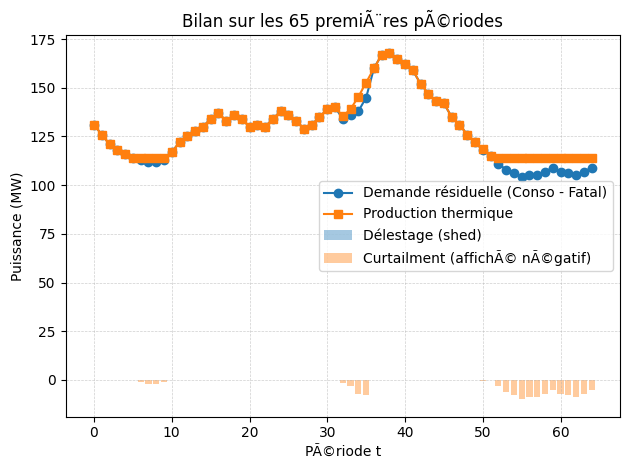

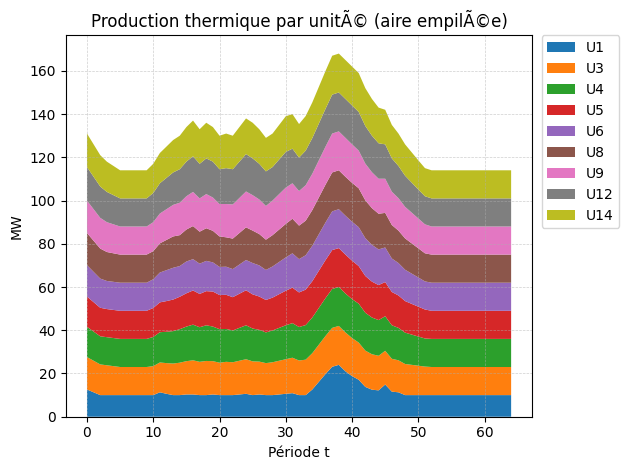

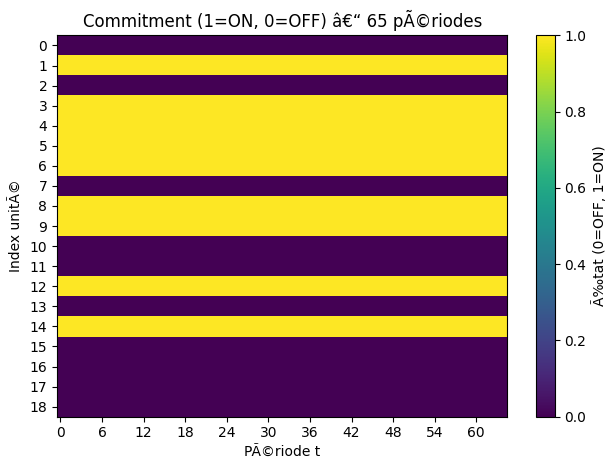

In [ ]:
# ========= PLOTS AMELIORES (légendes & lisibilité) =========
import matplotlib.pyplot as plt
import numpy as np

m, u, v, w, p, shed, curt = solve(0)

for t in range(1, T):
    print(p[(9, t)].value()-p[(9, t-1)].value())

curt_agg = [sum(value(curt[(f, t)]) for f in range(GF)) for t in range(T)] #curt aggrégé

def _val(x):  # sécurité (None -> 0.0)    
    return 0.0 if x is None else float(x)

thermal_gen = [sum(_val(p[(g, t)].value()) for g in range(G)) for t in range(T)]
shed_series  = [_val(shed[t].value()) for t in range(T)]
curt_series  = [_val(curt_agg[t]) for t in range(T)]

# ---------- Plot A : Bilan puissance ----------
plt.figure()
plt.plot(range(T), residual_demand, marker='o', label='Demande résiduelle (Conso - Fatal)')
plt.plot(range(T), thermal_gen, marker='s', label='Production thermique')
plt.bar(range(T), shed_series, alpha=0.4, label='Délestage (shed)')
plt.bar(range(T), [-c for c in curt_series], alpha=0.4, label='Curtailment (affiché négatif)')

plt.xlabel('Période t')
plt.ylabel('Puissance (MW)')
plt.title(f'Bilan sur les {T} premières périodes')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(loc='best', frameon=True)
plt.tight_layout()
plt.show()

# ---------- Plot B : Empilement par unité ----------
# On n'affiche que les unités actives pour une légende plus utile 
prod_mat = np.array([[ _val(p[(g, t)].value()) for t in range(T)] for g in range(G)])
active_units = [g for g in range(G) if prod_mat[g].sum() > 1e-9]
if not active_units:  # fallback si aucune unité n'a produit
    active_units = list(range(G))

x = range(T)
plt.figure()
plt.stackplot(x, [prod_mat[g] for g in active_units],
              labels=[f"U{g}" for g in active_units], baseline='zero')

plt.xlabel('Période t')
plt.ylabel('MW')
plt.title('Production thermique par unité (aire empilée)')
# Légende en dehors si elle est longue
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0., frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

# ---------- Plot C : Heatmap du commitment (0/1) ----------
commit_mat = np.array([[ int(round(_val(u[(g, t)].value()))) for t in range(T)] for g in range(G)])
plt.figure()
im = plt.imshow(commit_mat, aspect='auto', interpolation='nearest')

plt.xlabel('Période t')
plt.ylabel('Index unité')
plt.title(f'Commitment (1=ON, 0=OFF) – {T} périodes')
cbar = plt.colorbar(im)
cbar.set_label('État (0=OFF, 1=ON)', rotation=90)

# Ticks lisibles (pas trop denses)
step_x = max(1, T // 10)
plt.xticks(np.arange(0, T, step_x))
step_y = max(1, G // 10)
plt.yticks(np.arange(0, G, step_y))

# Option : Écrire 0/1 dans chaque cellule si la matrice n'est pas trop grande
if T * G <= 400:
    for g in range(G):
        for t in range(T):
            plt.text(t, g, commit_mat[g, t],
                     ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

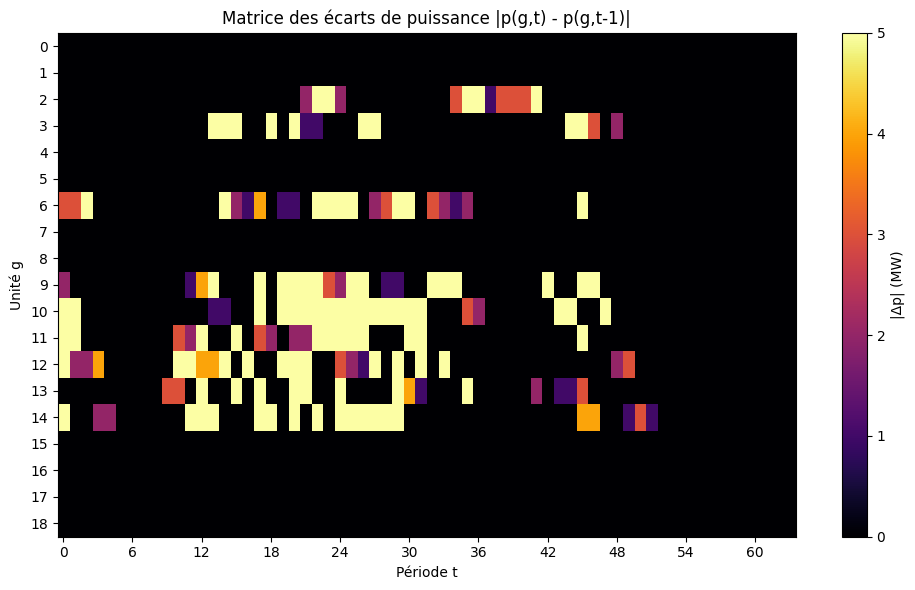

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pulp import value  
# --- Calcul de la matrice des écarts absolus |Δp|
grad_mat = np.zeros((G, T-1))
for g in range(G):
    for t in range(1, T):
        p_now = value(p[(g, t)])
        p_prev = value(p[(g, t-1)])
        if p_now is None or p_prev is None:
            grad_mat[g, t-1] = np.nan
        else:
            grad_mat[g, t-1] = abs(p_now - p_prev)

# --- Heatmap
plt.figure(figsize=(10, 6))
im = plt.imshow(grad_mat, aspect='auto', cmap='inferno', interpolation='nearest')
plt.colorbar(im, label='|Δp| (MW)')
plt.xlabel('Période t')
plt.ylabel('Unité g')
plt.title('Matrice des écarts de puissance |p(g,t) - p(g,t-1)|')

# Rendre les axes plus lisibles
step_x = max(1, T // 10)
plt.xticks(np.arange(0, T-1, step_x))
step_y = max(1, G // 10)
plt.yticks(np.arange(0, G, step_y))

plt.grid(False)
plt.tight_layout()
plt.show()


### Calcul des coûts et du CO2 à partir du modèle résolu

In [ ]:
def compute_CO2(m, u, v, w, p):
    def _val(x):
        return 0.0 if x is None else float(x)

    # --- 1. Calcul du CO₂ émis par pas de temps ---
    CO2_temps = [
        sum(_val(p[(g, t)].value()) * TauxCO2Thermique[g] for g in range(NbGroupeThermique)) + sum((TauxCO2Fatal[f] * (ProductionFatale[f][t]-_val(curt[(f, t)].value())) for f in range(GF)))
        for t in range(T)
    ]

    # --- 2. CO₂ total ---
    CO2_total = sum(CO2_temps)
    return CO2_total

In [ ]:
def compute_cost(m, u, v, w, p):

    def _val(x):
        return 0.0 if x is None else float(x)
        
    # --- 1. Coût de production total ---
    gen_cost = sum(
        _val(p[(g, t)].value()) * CoutThermiqueMoyen[g]
        for g in range(G) for t in range(T)
    )

    # --- 2. Coût de démarrage total ---
    start_cost = sum(
        _val(v[(g, t)].value()) * CoutDemarrageFroidThermique[g]
        for g in range(G) for t in range(T)
    )

    # --- 3. Coût total ---
    total_cost = gen_cost + start_cost

    return total_cost

In [ ]:
def compute_all(lamb):
    m, u, v, w, p, shed, curt = solve(lamb)
    CO2 = compute_CO2(m, u, v, w, p)
    cost = compute_cost(m, u, v, w, p)
    print(f"Le CO2 émis est : {CO2} tandis que le coût total est {cost}, pour un lambda de {lamb}")
    return np.array([CO2, cost, lamb])

In [ ]:
compute_all(0)

Le CO2 émis est : 3137382.0 tandis que le coût total est 463398.0, pour un lambda de 0


array([3137382.,  463398.,       0.])

### Tracé du front de Pareto (sans recherche intelligente pour les lambda)

3.0
3.6
1.8
0.4
0.5
0.4
0.5
0.4
0.5
0.4
0.4
0.4
0.5
0.4
0.5
1.5
1.8
1.2
1.5
Le CO2 émis est : 3347137.800000001 tandis que le coût total est 481343.0, pour un lambda de 0.001
3.0
3.6
1.8
0.4
0.5
0.4
0.5
0.4
0.5
0.4
0.4
0.4
0.5
0.4
0.5
1.5
1.8
1.2
1.5
Le CO2 émis est : 3347137.800000001 tandis que le coût total est 481343.0, pour un lambda de 0.004641588833612777
3.0
3.6
1.8
0.4
0.5
0.4
0.5
0.4
0.5
0.4
0.4
0.4
0.5
0.4
0.5
1.5
1.8
1.2
1.5
Le CO2 émis est : 3347137.800000001 tandis que le coût total est 481343.0, pour un lambda de 0.021544346900318832
3.0
3.6
1.8
0.4
0.5
0.4
0.5
0.4
0.5
0.4
0.4
0.4
0.5
0.4
0.5
1.5
1.8
1.2
1.5
Le CO2 émis est : 3341549.8 tandis que le coût total est 481512.0, pour un lambda de 0.1
3.0
3.6
1.8
0.4
0.5
0.4
0.5
0.4
0.5
0.4
0.4
0.4
0.5
0.4
0.5
1.5
1.8
1.2
1.5
Le CO2 émis est : 3341476.4000000004 tandis que le coût total est 481526.0, pour un lambda de 0.46415888336127775
3.0
3.6
1.8
0.4
0.5
0.4
0.5
0.4
0.5
0.4
0.4
0.4
0.5
0.4
0.5
1.5
1.8
1.2
1.5
Le CO2 émis es

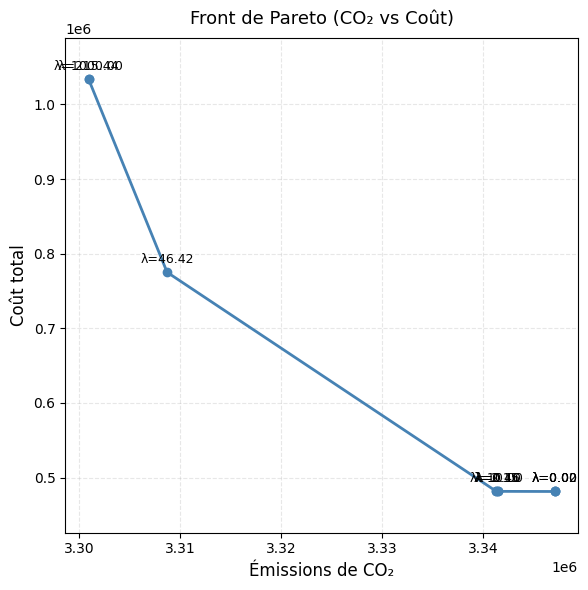

In [ ]:
from matplotlib import cm

def front_pareto(nb_pts):
    lambdas = np.logspace(-3, 3, nb_pts) #logpsace
    points = []
    for lamb in lambdas:
        point = compute_all(lamb)
        points.append(point)
    points = np.array(points)
    print(points)
    return points

def plot_front_pareto(nb_pts):

    points = np.array(front_pareto(nb_pts))  # [[CO2, cout, lambda], ...]

    # Tri par lambda pour lisser la courbe
    points = points[np.argsort(points[:, 2])]
    CO2, cout, lambdas = points[:, 0], points[:, 1], points[:, 2]

    fig, ax = plt.subplots(figsize=(6, 6))  # carré = proportions propres
    
    # Tracé principal
    ax.plot(CO2, cout, '-o', color='steelblue', linewidth=2, markersize=6)
    
    # Calcul d’un décalage vertical relatif à la taille du graphe
    y_range = cout.max() - cout.min()
    y_offset = 0.015 * y_range  # 1.5% du range vertical → léger mais visible

    # Labels λ juste au-dessus des points
    for x, y, lamb in zip(CO2, cout, lambdas):
        ax.text(
            x, y + y_offset,
            f"λ={lamb:.2f}",
            fontsize=9,
            ha='center', va='bottom',
            color='black'
        )

    # Axes propres
    ax.set_xlabel("Émissions de CO₂", fontsize=12)
    ax.set_ylabel("Coût total", fontsize=12)
    ax.set_title("Front de Pareto (CO₂ vs Coût)", fontsize=13, pad=10)
    ax.grid(True, linestyle='--', alpha=0.3)

    # Ajuste l’échelle pour que le graphe ne soit ni trop serré ni déséquilibré
    ax.margins(x=0.05, y=0.1)

    # Échelles log si nécessaire (évaluation automatique)
    if CO2.max() / CO2.min() > 100:
        ax.set_xscale('log')
    if cout.max() / cout.min() > 100:
        ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_front_pareto(10)

CO₂ total émis sur l'horizon : 3135201.00 kilos


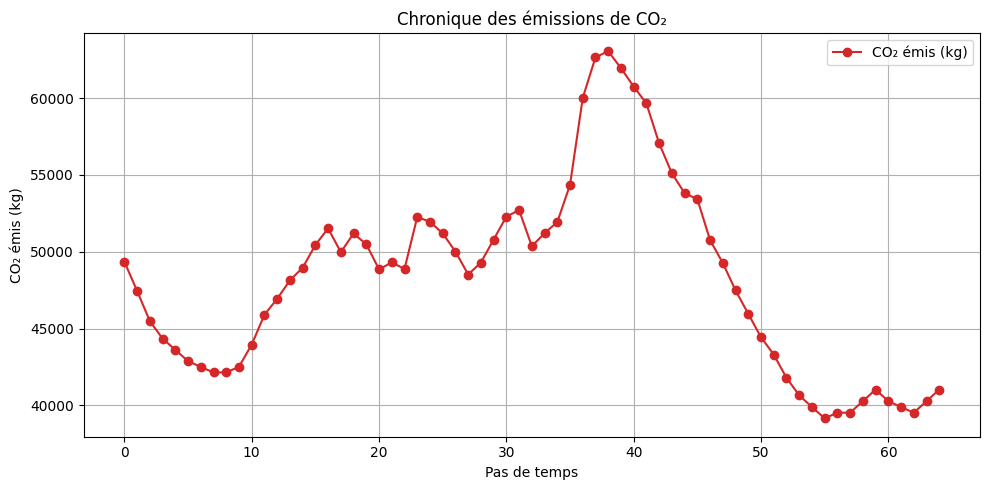

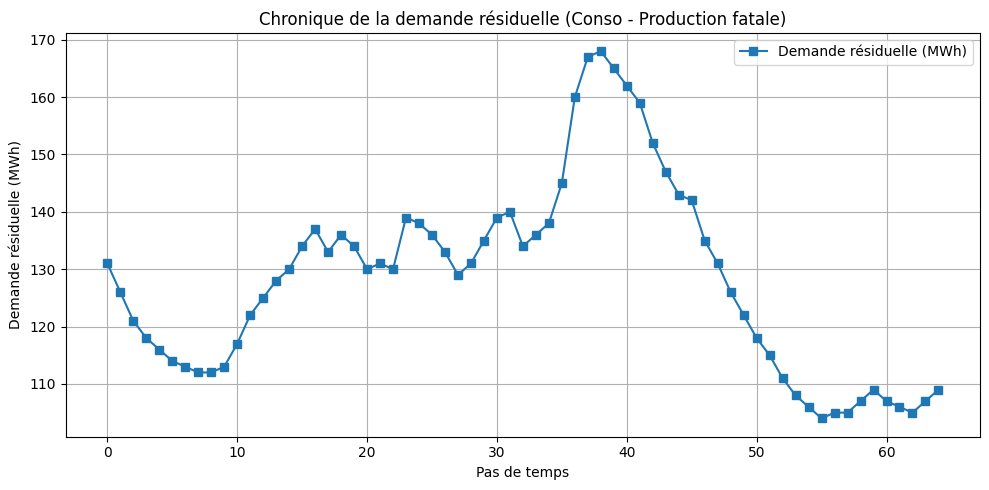

In [ ]:
def _val(x):
    return 0.0 if x is None else float(x)

# --- 1. Calcul du CO₂ émis par pas de temps ---
CO2_temps = [
    sum(_val(p[(g, t)].value()) * TauxCO2Thermique[g] for g in range(NbGroupeThermique))
    for t in range(T)
]

# --- 2. CO₂ total ---
CO2_total = sum(CO2_temps)
print(f"CO₂ total émis sur l'horizon : {CO2_total:.2f} kilos")

# --- 3. Calcul de la demande résiduelle (défalquée de la production fatale) ---
fatal_sum = [sum(ProductionFatale[f][t] for f in range(NbGroupeFatal)) for t in range(T)]
residual_demand = [Conso[t] - fatal_sum[t] for t in range(T)]

# --- 4. Affichage graphique ---
import matplotlib.pyplot as plt

# --- Graphique 1 : CO₂ émis ---
plt.figure(figsize=(10, 5))
plt.plot(range(T), CO2_temps, color='tab:red', marker='o', label='CO₂ émis (kg)')
plt.title("Chronique des émissions de CO₂")
plt.xlabel("Pas de temps")
plt.ylabel("CO₂ émis (kg)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Graphique 2 : Demande résiduelle ---
plt.figure(figsize=(10, 5))
plt.plot(range(T), residual_demand, color='tab:blue', marker='s', label='Demande résiduelle (MWh)')
plt.title("Chronique de la demande résiduelle (Conso - Production fatale)")
plt.xlabel("Pas de temps")
plt.ylabel("Demande résiduelle (MWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
